## Evocação do ritmo alpha

### 1. Importação das bibliotecas

In [30]:
%matplotlib inline

import matplotlib.pyplot as plt
import mne
import numpy as np
from copy import deepcopy
from mne.time_frequency import psd_welch as pw

### 2. Definição dos eletrodos e frequências

In [31]:
ch_names = ['po3', 'po4', 'p8', 'o1', 'o2', 'p7']
alpha = []
beta = []
theta = []
gamma = []
md_alpha = []
md_beta = []
md_theta = []
md_gamma = []
md_ritmos = []

### 3. Leitura do arquivo

A função a seguir (*load\_data*) faz o carregamento do arquivo com o conjunto de frequências _alpha_, _beta_, _gamma_, _delta_ e _theta_, obtidas a partir das leituras dos eletrodos definidos anteriormente.

In [32]:
def load_data(file):
    with open(file, 'r') as f:
        data = f.readlines()
    
    compactData = []
    for i in range(len(data)):
        if i >= 6:
            compactData.append(data[i])

    return compactData

### 4. Extração das informações relativas às frequências

A seguir são apresentadas duas funções: _convert_ e *separate\_data*. A primeira retorna um array com as informações relativas apenas aos dados de frequência de uma linha de arquivo passada como parâmetro, pois as linhas do arquivo eram compostas por ID's, tempo e leitura de eletrodos que não eram importantes nesse momento. Já a segunda função faz um mapeamento dos segundos que não possuíam leitura completa, isto é, o arquivo é composto por vários blocos de 256 itens, sendo que cada bloco desse corresponde à leitura de 1 segundo. Porém, alguns desses blocos tinham informações faltando, nao tinham os 256 itens. Dessa forma, a função *separate\_data* percorre o arquivo identificando quais são esses blocos defeituosos e, ao final, retorna um array com as informações relativas apenas às frequências (usa a função _convert_ para isso) dos segundos que possuem todas as informações.

In [33]:
def convert(data):
    temp = []
    line = data.split(',')

    for e in range(len(line)):
        if e > 0 and e <= 6:
            temp.append(float(line[e]))
    
    return temp

def separate_data(data):
    index = []
    temp = []
    count = 0

    for e in range(len(data)):
        idx = data[e].split(',')[0]
        if int(idx) == 255 and count == 255:
            index.extend(temp)
            temp = []
            count = 0
        elif int(idx) == 255 and count < 255:
            temp = []
            count = 0
        else:
            temp.append(convert(data[e]))
            count += 1
    
    return index

In [34]:
data = load_data('dataset_alpha/RAW_00.txt')
newData = separate_data(data)
size = int(len(newData)/256)

### 5. Plotando gráfico com os dados originais

A função *plot\_graph* constrói o gráfico com a leitura das frequências obtida dos dados. Até o momento, os dados estão em seu estado original, sem a aplicação de nenhum tipo de filtro.

In [35]:
def plot_graph(data):
    newData = np.asarray(data)
    newData = newData.T
    ch_types = ['eeg'] * 6

    info = mne.create_info(ch_names=ch_names, sfreq=256, ch_types=ch_types)
    raw = mne.io.RawArray(newData, info, verbose=False)
    
    montage = mne.channels.read_montage('standard_1020')
    raw.set_montage(montage)
    
    print("*******Dados originais*******\n")
    raw.plot_psd()
    return raw

*******Dados originais*******



<ipython-input-35-89cf24c02c2f>:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  raw.plot_psd()


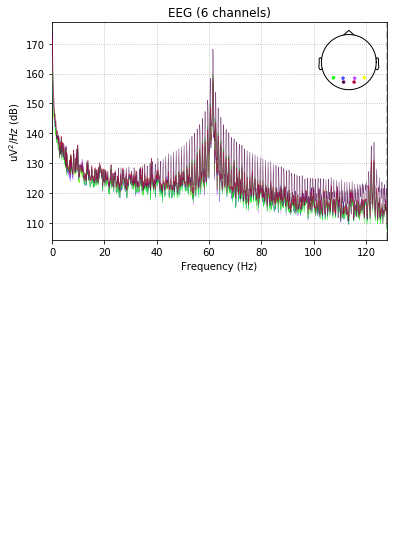

In [36]:
raw = plot_graph(newData)

### 6. Aplicando filtro notch

Com o intuito de reduzir o ruído nos dados, a função a seguir faz a aplicação do filtro notch.

In [37]:
def apply_notch(raw):
    newRaw = deepcopy(raw)
    newRaw.notch_filter(np.arange(60, 121, 60), fir_design='firwin')
    newRaw.filter(8., 50., fir_design='firwin')
    
    print("*******Dados com filtro notch*******\n")
    newRaw.plot_psd(area_mode='range', verbose=False)
    print()
    return newRaw

*******Dados com filtro notch*******



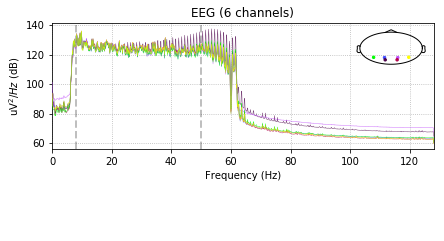

In [38]:
raw = apply_notch(raw)

### 7. Aplicando filtro bandpass

Para reduzir ainda mais os ruídos, a função a seguir aplica 10 vezes o filtro bandpass nos dados.

In [39]:
def apply_bandpass(raw):
    newRaw = deepcopy(raw)
    
    for i in range(0, 9):
        newRaw.filter(l_freq=8., h_freq=50.)
    
    print("*******Dados com filtro bandpass*******\n")
    newRaw.plot_psd(area_mode='range', fmin=8, fmax=50, tmin=0, tmax=800, verbose=False)
#     print()
    return newRaw

### 8. Média quadrática

A função a seguir realiza a média quadrática de um array passado como parâmetro.

In [40]:
def avg(data):
    soma = 0
    for i in range(0, len(data)):
        soma = data[i] ** 2
    res = soma/len(data)
    res = res ** 1/2
    return res

### 9. Janelamento com psd_welch

Foi feita uma análise dos dados por meio da ferramenta openBCI e, com isso, verificou-se quais foram os intervalos de tempo em que o ritmo _alpha_ estava mais alto. A tabela a seguir apresenta esses intervalos. Vale ressaltar que o tempo total era de 830 segundos.

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-baqh{text-align:center;vertical-align:top}
.tg .tg-c3ow{border-color:inherit;text-align:center;vertical-align:top}
.tg .tg-uys7{border-color:inherit;text-align:center}
.tg .tg-0lax{text-align:left;vertical-align:top}
</style>
<table class="tg" style="undefined;table-layout: fixed; width: 254px">
<colgroup>
<col style="width: 124px">
<col style="width: 130px">
</colgroup>
  <tr>
    <th class="tg-uys7"><span style="font-weight:bold">Início (s)</span></th>
    <th class="tg-uys7"><span style="font-weight:bold">Fim (s)</span></th>
  </tr>
  <tr>
    <td class="tg-uys7">11</td>
    <td class="tg-uys7">13</td>
  </tr>
  <tr>
    <td class="tg-uys7">77</td>
    <td class="tg-uys7">85</td>
  </tr>
  <tr>
    <td class="tg-c3ow">121</td>
    <td class="tg-c3ow">122</td>
  </tr>
  <tr>
    <td class="tg-c3ow">124</td>
    <td class="tg-c3ow">127</td>
  </tr>
  <tr>
    <td class="tg-baqh">198</td>
    <td class="tg-baqh">199</td>
  </tr>
  <tr>
    <td class="tg-baqh">244</td>
    <td class="tg-baqh">250</td>
  </tr>
  <tr>
    <td class="tg-baqh">252</td>
    <td class="tg-baqh">258</td>
  </tr>
  <tr>
    <td class="tg-baqh">300</td>
    <td class="tg-baqh">304</td>
  </tr>
  <tr>
    <td class="tg-baqh">314</td>
    <td class="tg-baqh">320</td>
  </tr>
  <tr>
    <td class="tg-baqh">410</td>
    <td class="tg-baqh">411</td>
  </tr>
  <tr>
    <td class="tg-0lax">607</td>
    <td class="tg-0lax">611</td>
  </tr>
</table>

A função a seguir constrói o gráfico para os intervalos passados como parâmetro e salva as intensidades dos eletrodos para cada um dos tipos de frequência.

In [51]:
def plot_time_frequency(raw, i, f):
    newRaw = (apply_bandpass(raw))
    
    psds, freqs = pw(newRaw, 5., 50., i, f)
    print("*******Dados após psd_welch*******\n")        
    for j in range(0, 6):
        theta.append(psds[j][0:3])
        alpha.append(psds[j][3:8])
        beta.append(psds[j][8:25])
        gamma.append(psds[j][20:46])

        plt.plot(freqs, psds[j], linewidth=2)
        plt.legend(ch_names)
    avg_freq()

*******Dados com filtro bandpass*******



<ipython-input-39-3268eb497e71>:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  newRaw.plot_psd(area_mode='range', fmin=8, fmax=50, tmin=0, tmax=800, verbose=False)


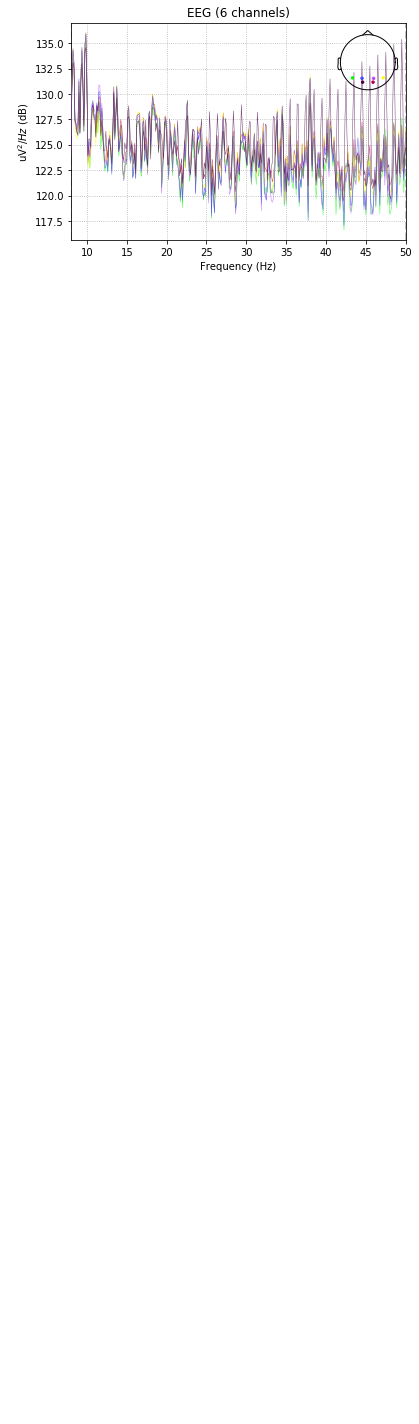

Effective window size : 1.000 (s)
*******Dados após psd_welch*******

*******Dados com filtro bandpass*******



<ipython-input-39-3268eb497e71>:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  newRaw.plot_psd(area_mode='range', fmin=8, fmax=50, tmin=0, tmax=800, verbose=False)


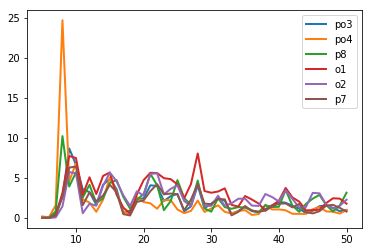

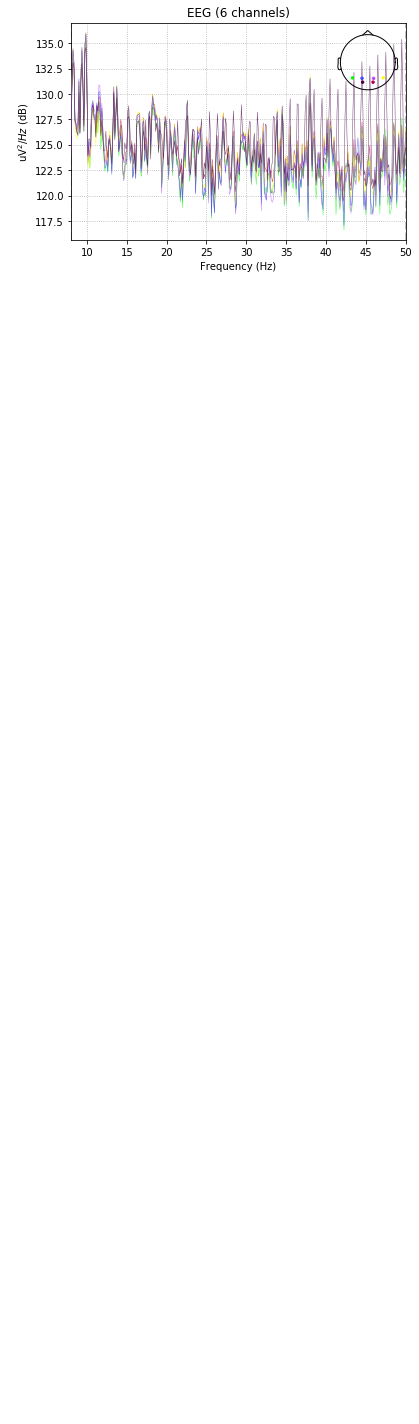

Effective window size : 1.000 (s)
*******Dados após psd_welch*******

*******Dados com filtro bandpass*******



<ipython-input-39-3268eb497e71>:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  newRaw.plot_psd(area_mode='range', fmin=8, fmax=50, tmin=0, tmax=800, verbose=False)


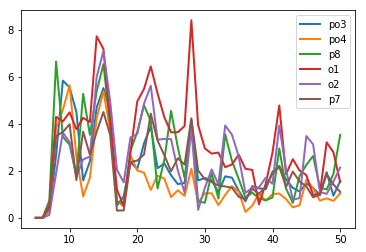

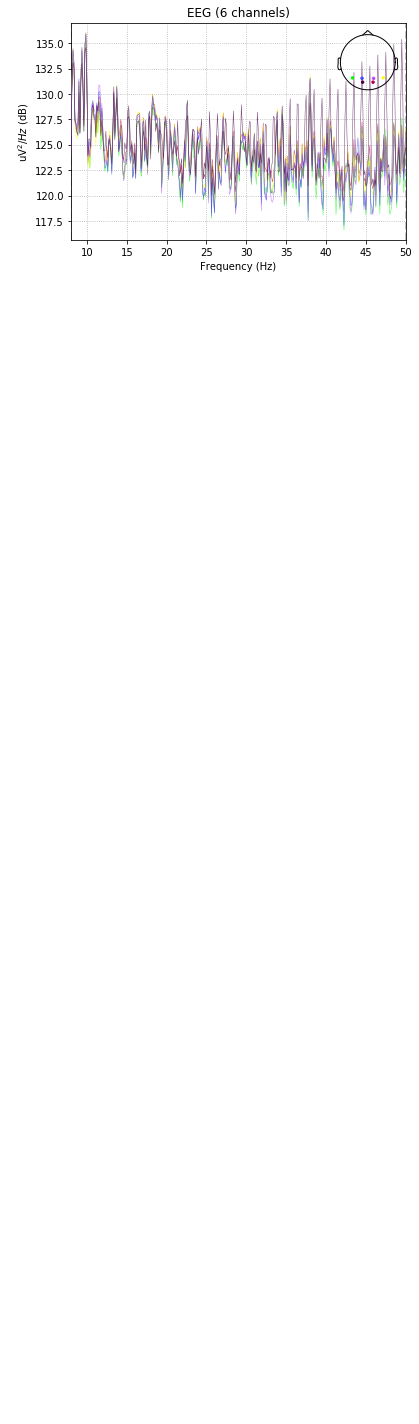

Effective window size : 1.000 (s)
*******Dados após psd_welch*******

*******Dados com filtro bandpass*******



<ipython-input-39-3268eb497e71>:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  newRaw.plot_psd(area_mode='range', fmin=8, fmax=50, tmin=0, tmax=800, verbose=False)


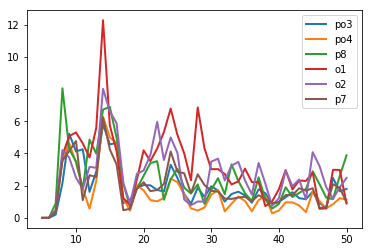

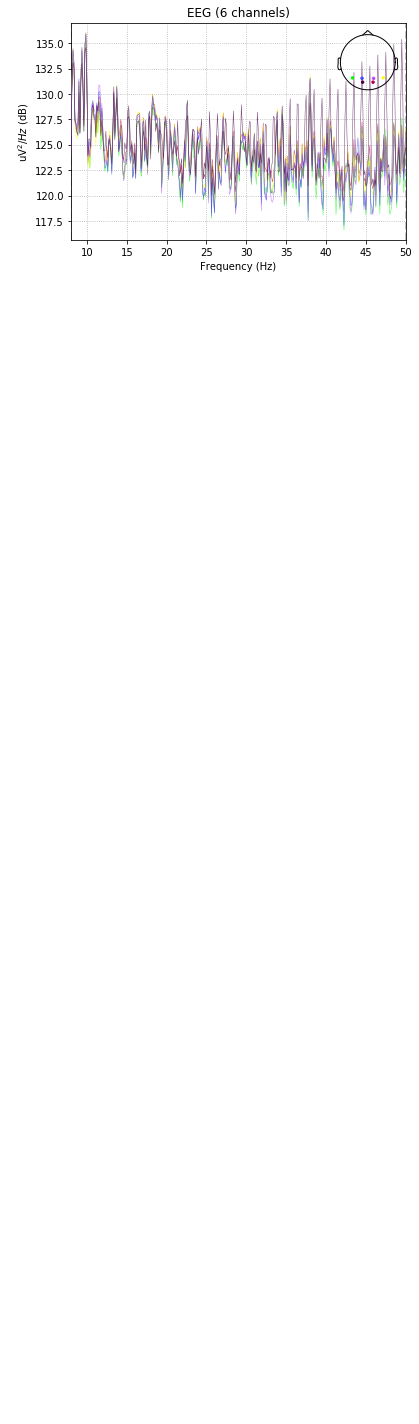

Effective window size : 1.000 (s)
*******Dados após psd_welch*******

*******Dados com filtro bandpass*******



<ipython-input-39-3268eb497e71>:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  newRaw.plot_psd(area_mode='range', fmin=8, fmax=50, tmin=0, tmax=800, verbose=False)


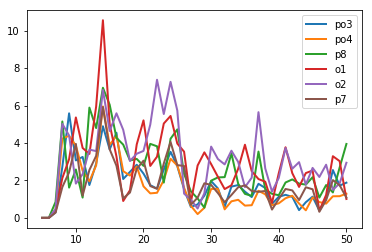

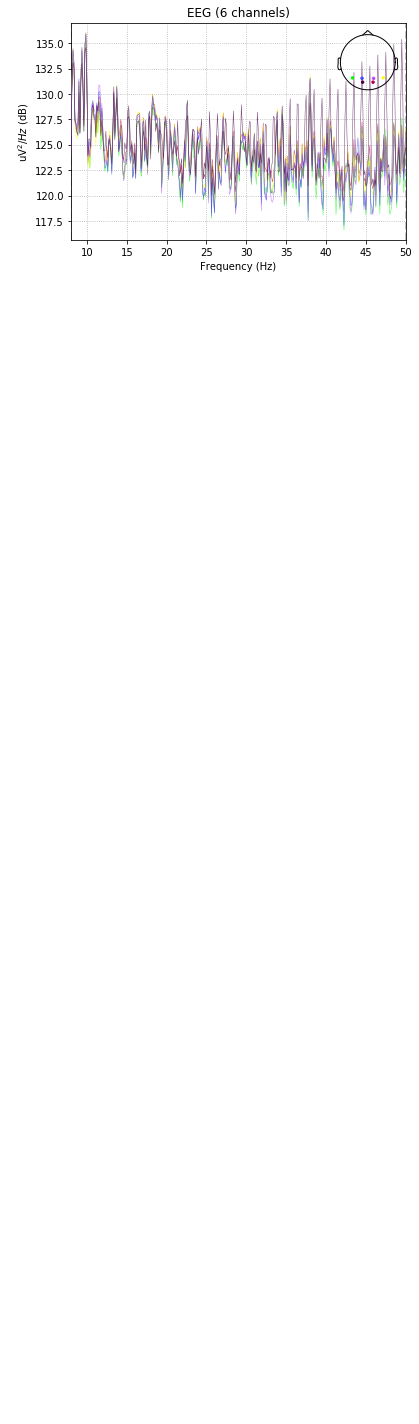

Effective window size : 1.000 (s)
*******Dados após psd_welch*******

*******Dados com filtro bandpass*******



<ipython-input-39-3268eb497e71>:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  newRaw.plot_psd(area_mode='range', fmin=8, fmax=50, tmin=0, tmax=800, verbose=False)


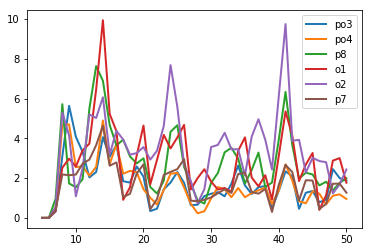

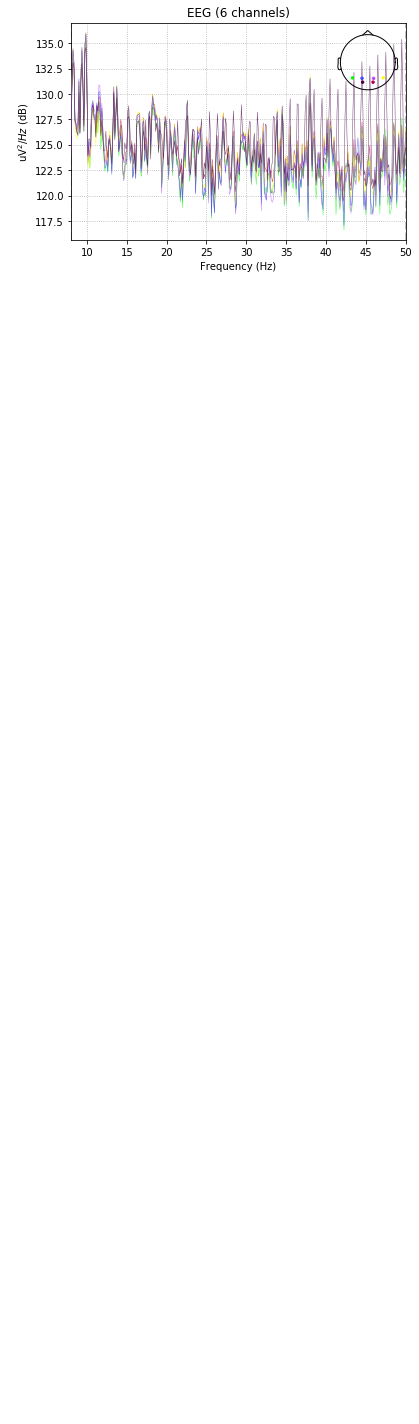

Effective window size : 1.000 (s)
*******Dados após psd_welch*******

*******Dados com filtro bandpass*******



<ipython-input-39-3268eb497e71>:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  newRaw.plot_psd(area_mode='range', fmin=8, fmax=50, tmin=0, tmax=800, verbose=False)


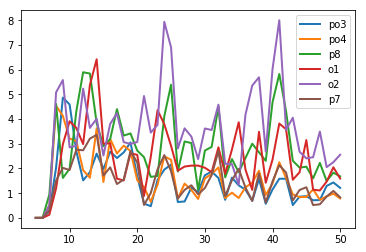

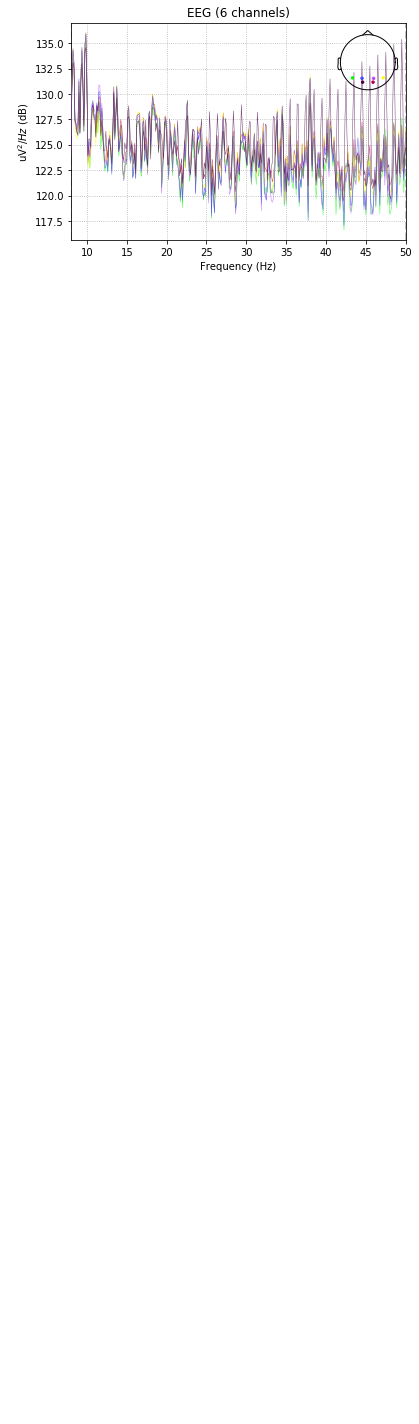

Effective window size : 1.000 (s)
*******Dados após psd_welch*******

*******Dados com filtro bandpass*******



<ipython-input-39-3268eb497e71>:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  newRaw.plot_psd(area_mode='range', fmin=8, fmax=50, tmin=0, tmax=800, verbose=False)


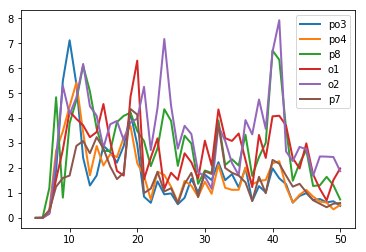

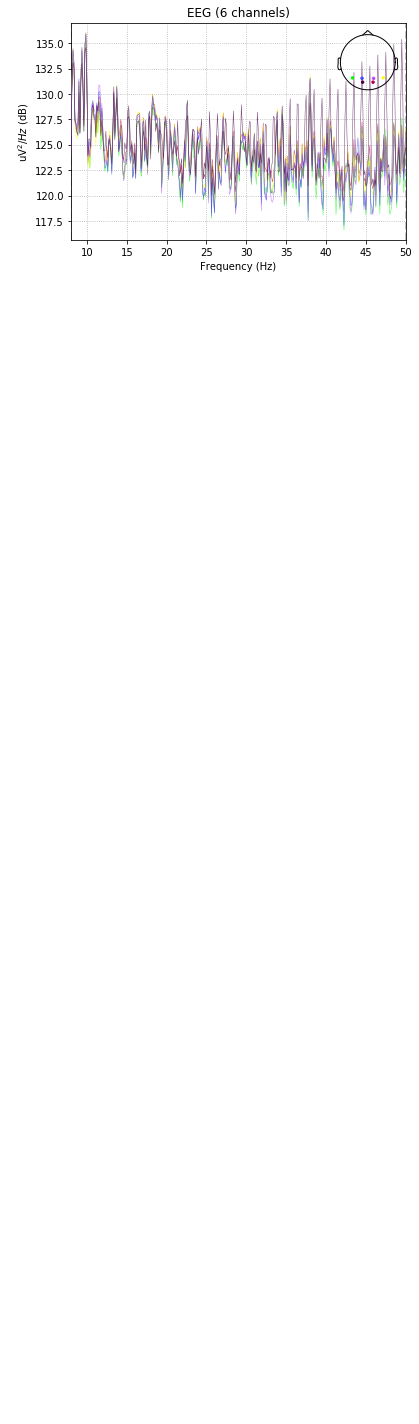

Effective window size : 1.000 (s)
*******Dados após psd_welch*******

*******Dados com filtro bandpass*******



<ipython-input-39-3268eb497e71>:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  newRaw.plot_psd(area_mode='range', fmin=8, fmax=50, tmin=0, tmax=800, verbose=False)


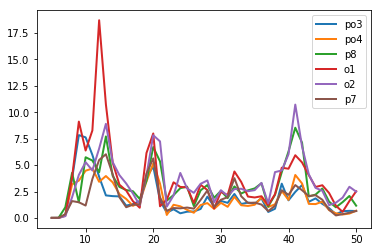

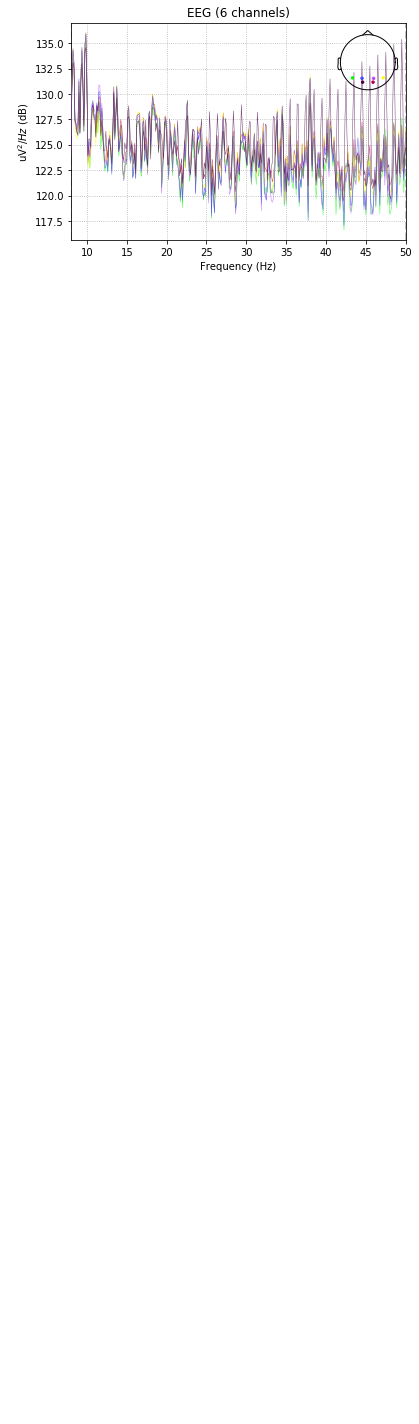

Effective window size : 1.000 (s)
*******Dados após psd_welch*******

*******Dados com filtro bandpass*******



<ipython-input-39-3268eb497e71>:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  newRaw.plot_psd(area_mode='range', fmin=8, fmax=50, tmin=0, tmax=800, verbose=False)


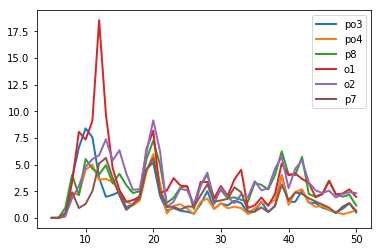

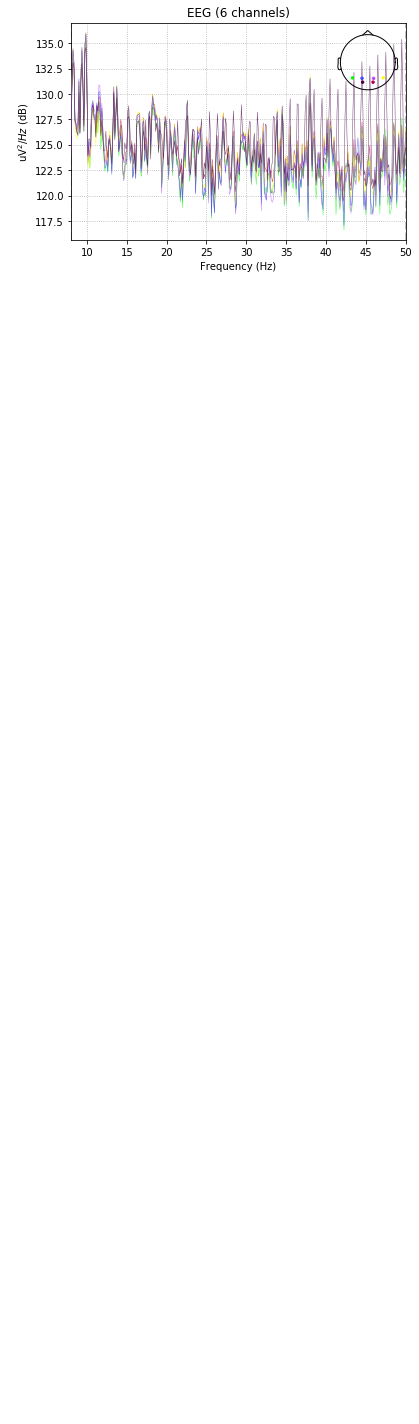

Effective window size : 1.000 (s)
*******Dados após psd_welch*******

*******Dados com filtro bandpass*******



<ipython-input-39-3268eb497e71>:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  newRaw.plot_psd(area_mode='range', fmin=8, fmax=50, tmin=0, tmax=800, verbose=False)


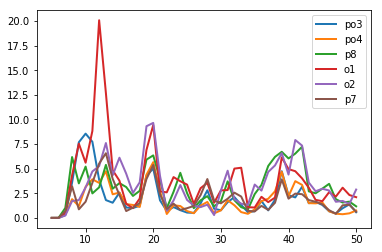

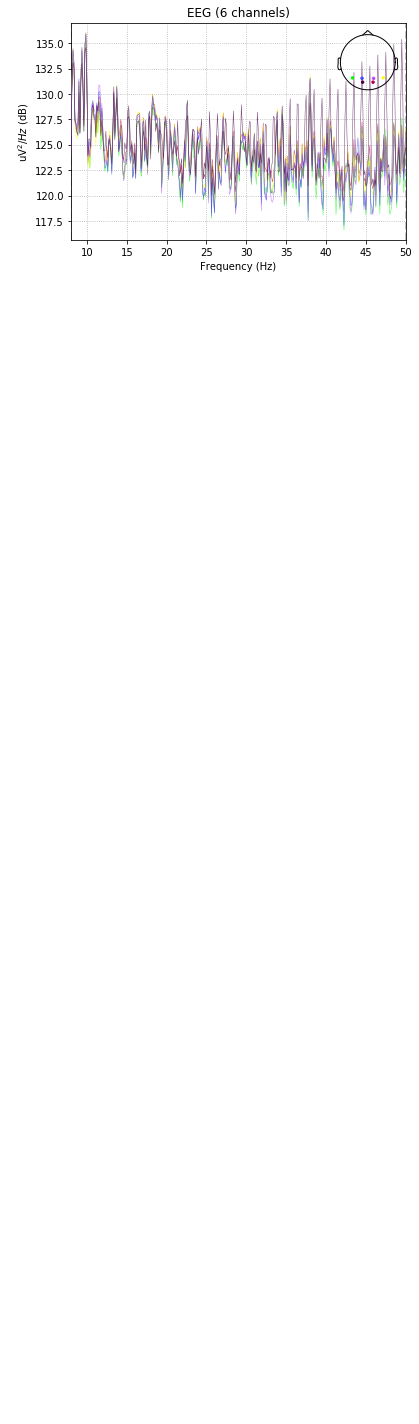

Effective window size : 1.000 (s)
*******Dados após psd_welch*******

*******Dados com filtro bandpass*******



<ipython-input-39-3268eb497e71>:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  newRaw.plot_psd(area_mode='range', fmin=8, fmax=50, tmin=0, tmax=800, verbose=False)


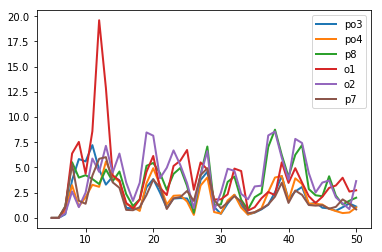

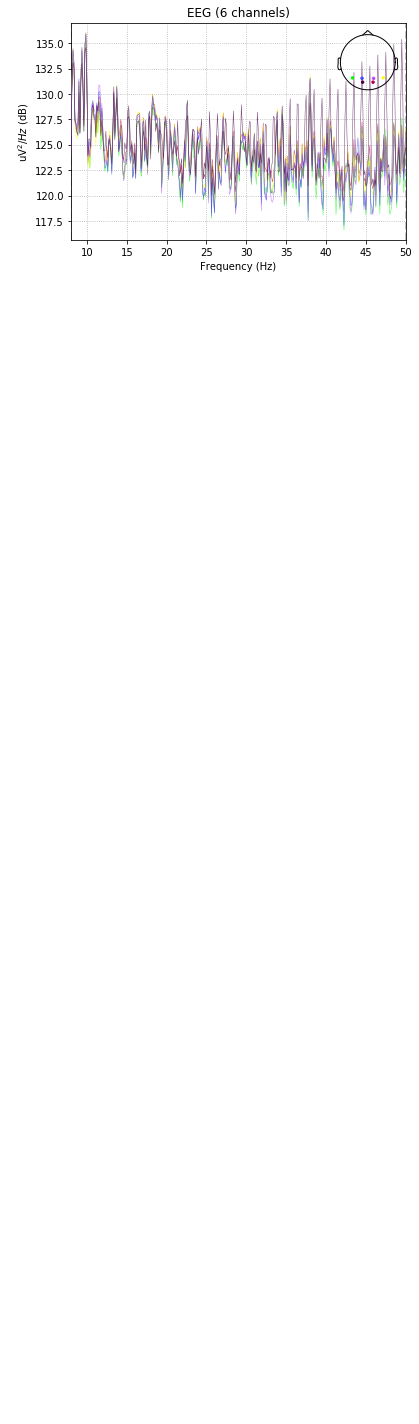

Effective window size : 1.000 (s)
*******Dados após psd_welch*******

*******Dados com filtro bandpass*******



<ipython-input-39-3268eb497e71>:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  newRaw.plot_psd(area_mode='range', fmin=8, fmax=50, tmin=0, tmax=800, verbose=False)


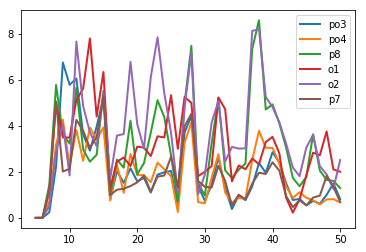

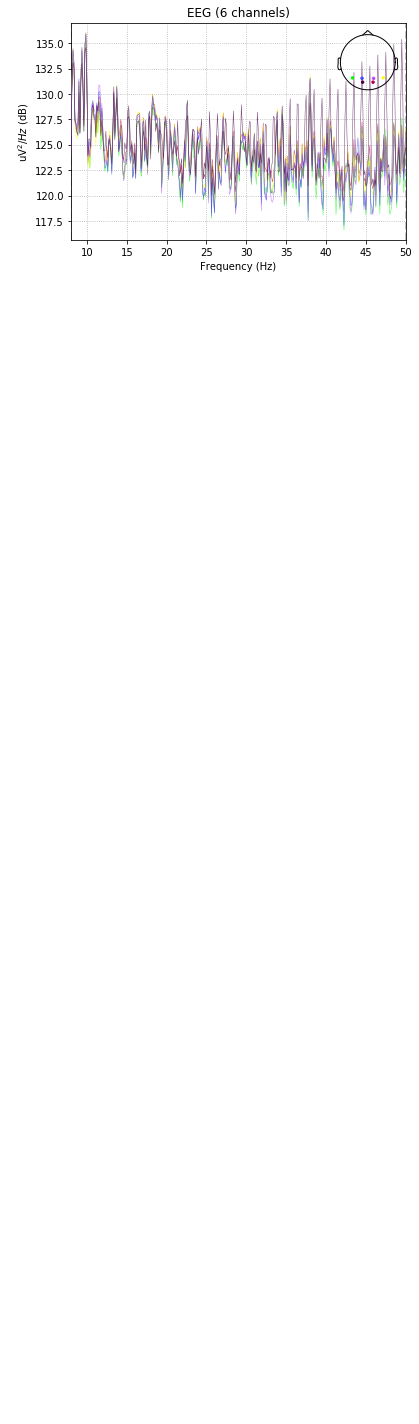

Effective window size : 1.000 (s)
*******Dados após psd_welch*******

*******Dados com filtro bandpass*******



<ipython-input-39-3268eb497e71>:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  newRaw.plot_psd(area_mode='range', fmin=8, fmax=50, tmin=0, tmax=800, verbose=False)


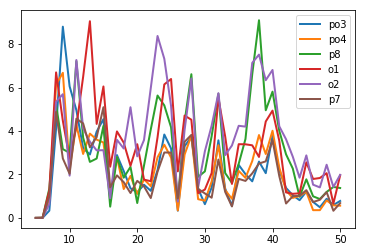

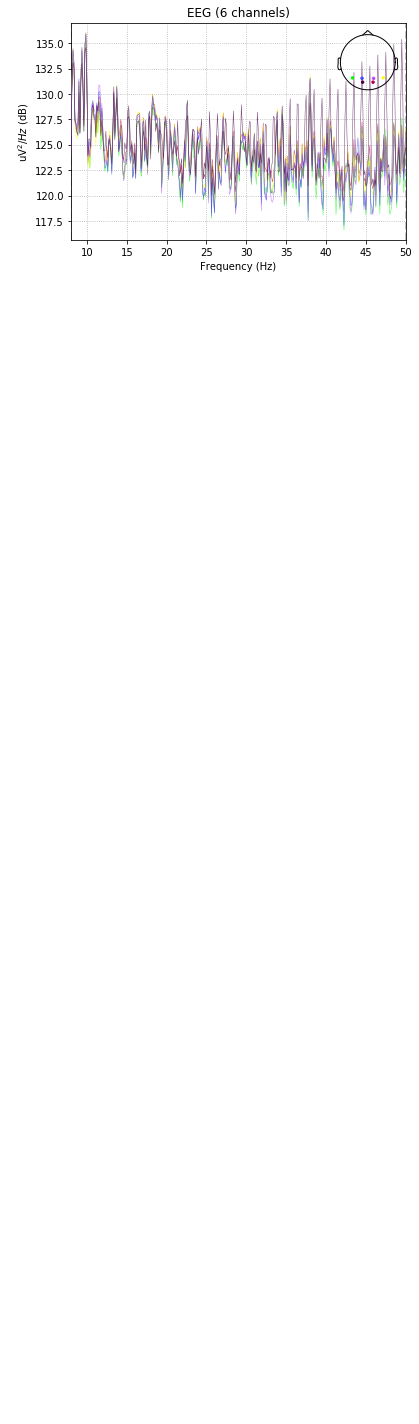

Effective window size : 1.000 (s)
*******Dados após psd_welch*******

*******Dados com filtro bandpass*******



<ipython-input-39-3268eb497e71>:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  newRaw.plot_psd(area_mode='range', fmin=8, fmax=50, tmin=0, tmax=800, verbose=False)


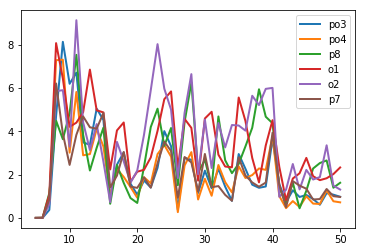

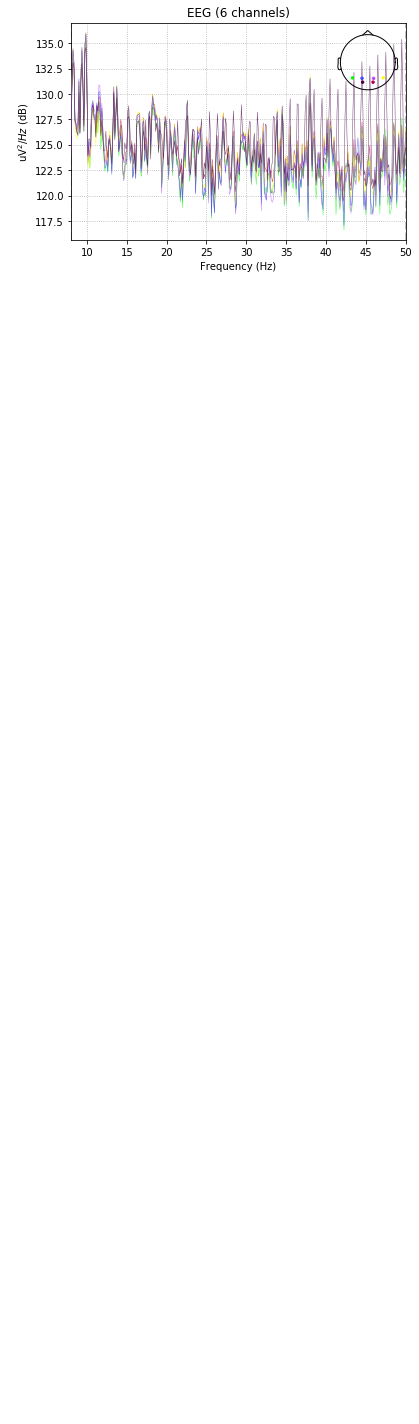

Effective window size : 1.000 (s)
*******Dados após psd_welch*******

*******Dados com filtro bandpass*******



<ipython-input-39-3268eb497e71>:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  newRaw.plot_psd(area_mode='range', fmin=8, fmax=50, tmin=0, tmax=800, verbose=False)


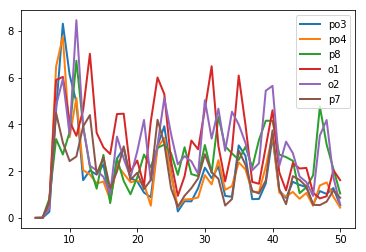

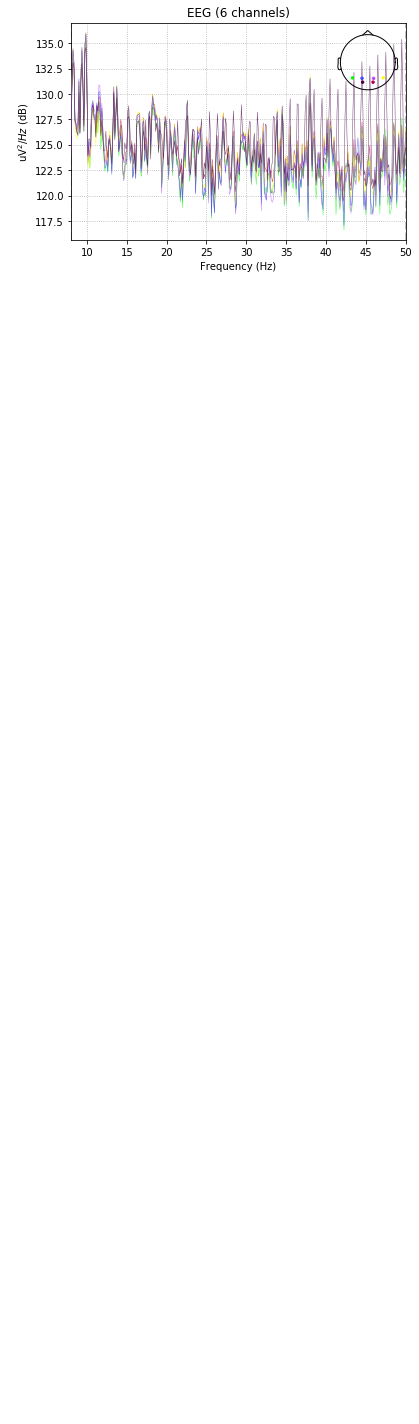

Effective window size : 1.000 (s)
*******Dados após psd_welch*******

*******Dados com filtro bandpass*******



<ipython-input-39-3268eb497e71>:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  newRaw.plot_psd(area_mode='range', fmin=8, fmax=50, tmin=0, tmax=800, verbose=False)


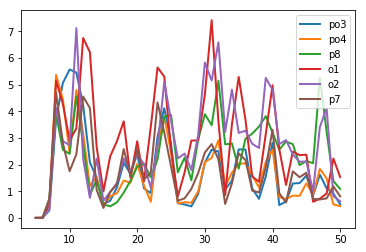

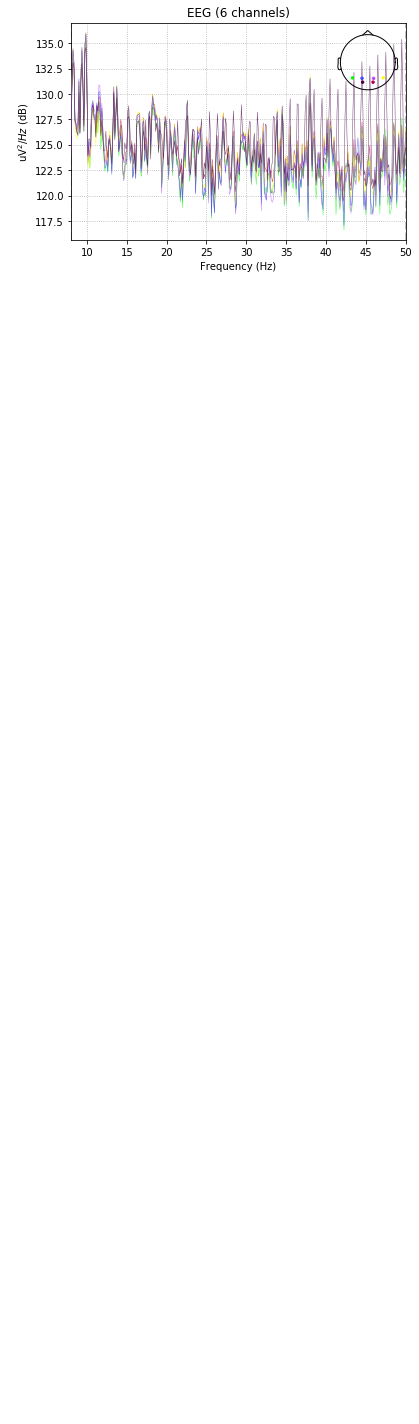

Effective window size : 1.000 (s)
*******Dados após psd_welch*******

*******Dados com filtro bandpass*******



<ipython-input-39-3268eb497e71>:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  newRaw.plot_psd(area_mode='range', fmin=8, fmax=50, tmin=0, tmax=800, verbose=False)


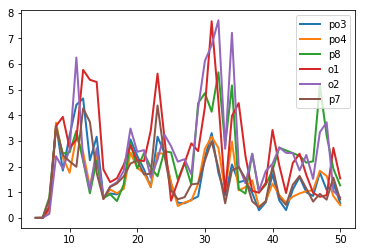

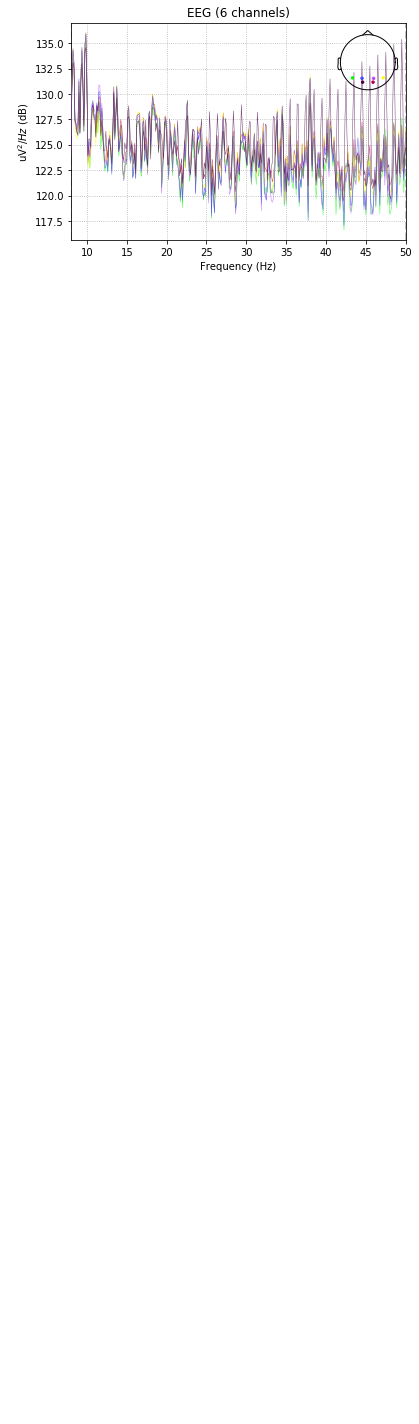

Effective window size : 1.000 (s)
*******Dados após psd_welch*******

*******Dados com filtro bandpass*******



<ipython-input-39-3268eb497e71>:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  newRaw.plot_psd(area_mode='range', fmin=8, fmax=50, tmin=0, tmax=800, verbose=False)


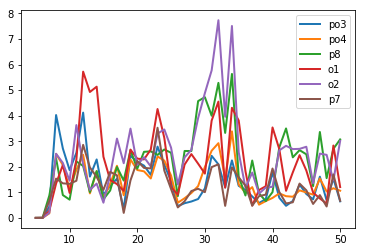

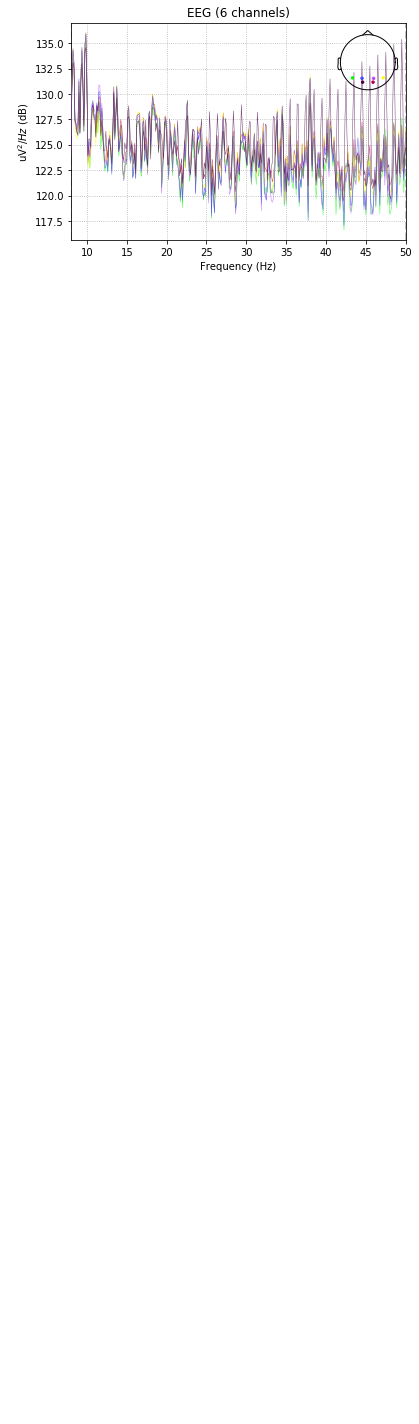

Effective window size : 1.000 (s)
*******Dados após psd_welch*******

*******Dados com filtro bandpass*******



<ipython-input-39-3268eb497e71>:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  newRaw.plot_psd(area_mode='range', fmin=8, fmax=50, tmin=0, tmax=800, verbose=False)


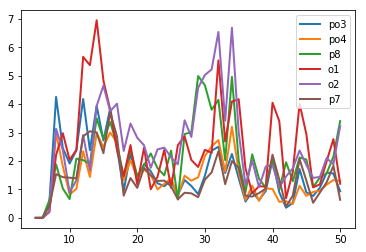

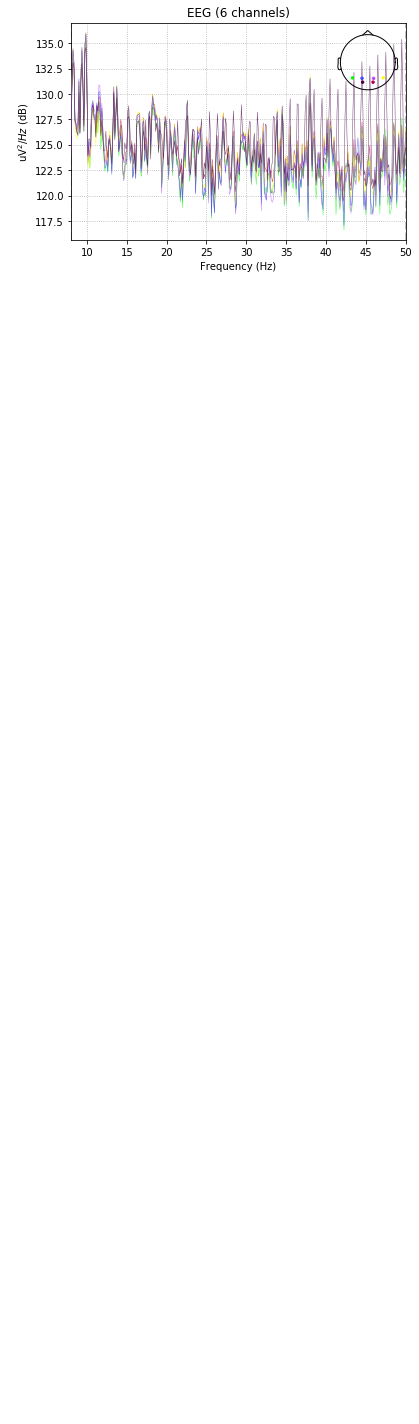

Effective window size : 1.000 (s)
*******Dados após psd_welch*******

*******Dados com filtro bandpass*******



<ipython-input-39-3268eb497e71>:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  newRaw.plot_psd(area_mode='range', fmin=8, fmax=50, tmin=0, tmax=800, verbose=False)


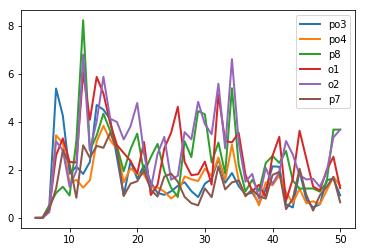

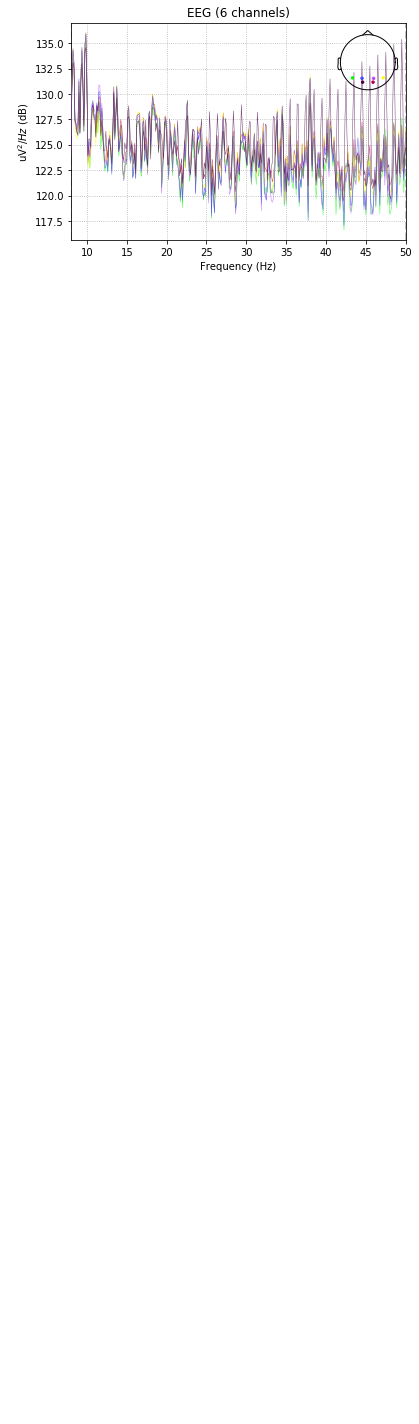

Effective window size : 1.000 (s)
*******Dados após psd_welch*******

*******Dados com filtro bandpass*******



<ipython-input-39-3268eb497e71>:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  newRaw.plot_psd(area_mode='range', fmin=8, fmax=50, tmin=0, tmax=800, verbose=False)


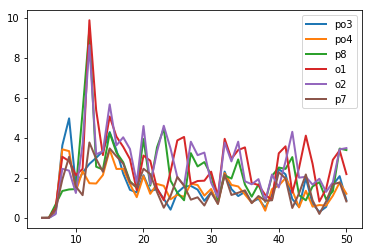

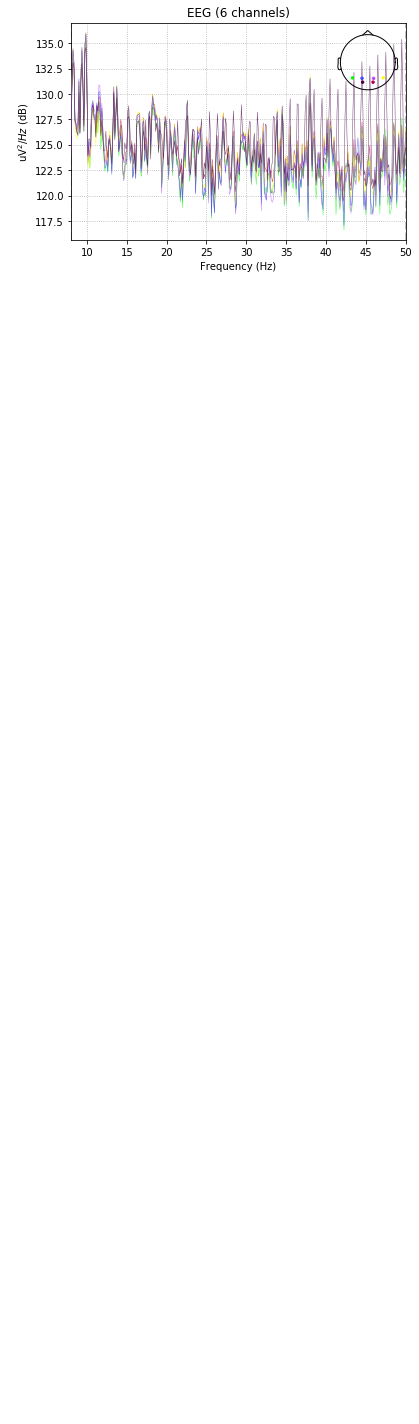

Effective window size : 1.000 (s)
*******Dados após psd_welch*******

*******Dados com filtro bandpass*******



<ipython-input-39-3268eb497e71>:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  newRaw.plot_psd(area_mode='range', fmin=8, fmax=50, tmin=0, tmax=800, verbose=False)


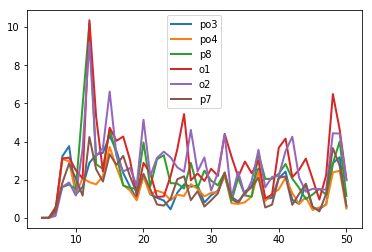

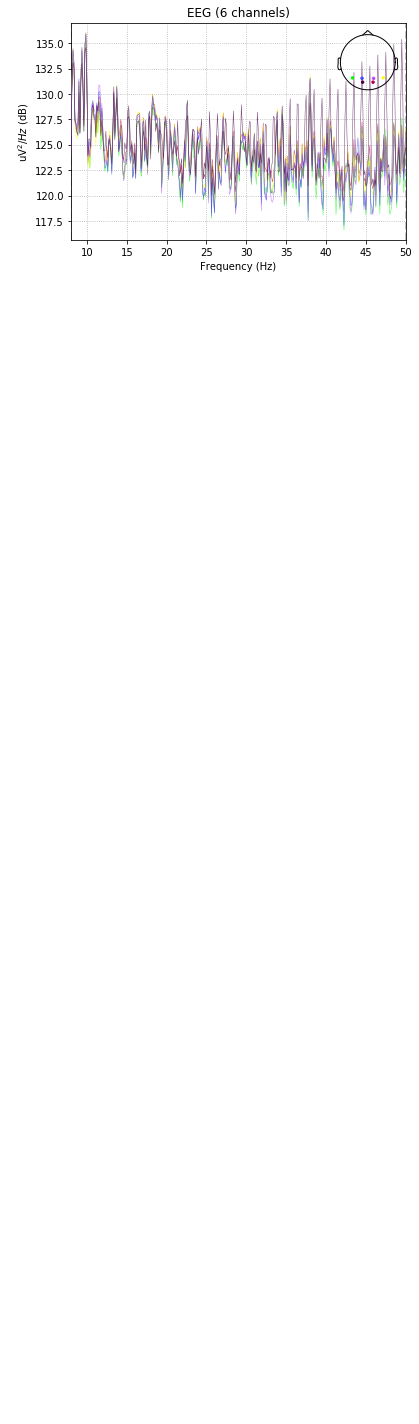

Effective window size : 1.000 (s)
*******Dados após psd_welch*******

*******Dados com filtro bandpass*******



<ipython-input-39-3268eb497e71>:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  newRaw.plot_psd(area_mode='range', fmin=8, fmax=50, tmin=0, tmax=800, verbose=False)


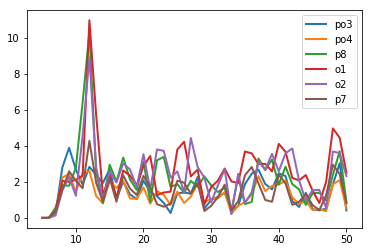

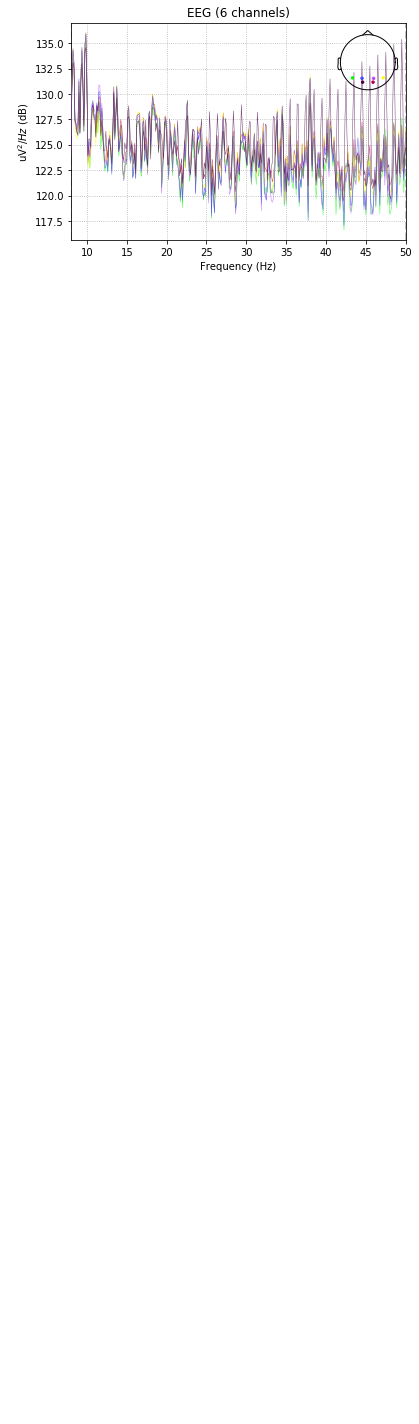

Effective window size : 1.000 (s)
*******Dados após psd_welch*******

*******Dados com filtro bandpass*******



<ipython-input-39-3268eb497e71>:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  newRaw.plot_psd(area_mode='range', fmin=8, fmax=50, tmin=0, tmax=800, verbose=False)


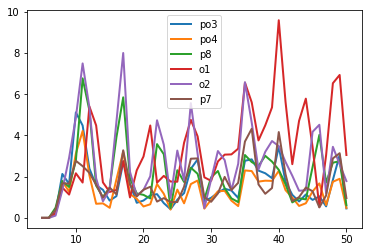

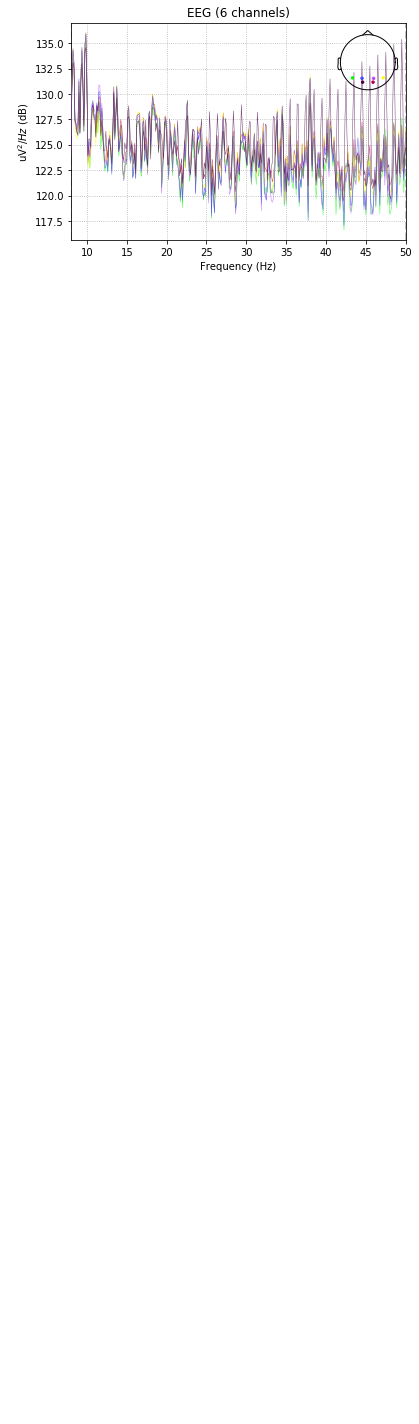

Effective window size : 1.000 (s)
*******Dados após psd_welch*******

*******Dados com filtro bandpass*******



<ipython-input-39-3268eb497e71>:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  newRaw.plot_psd(area_mode='range', fmin=8, fmax=50, tmin=0, tmax=800, verbose=False)


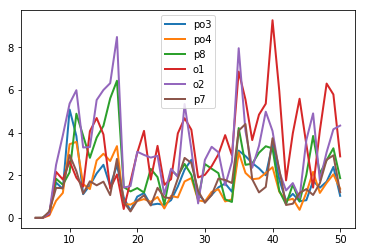

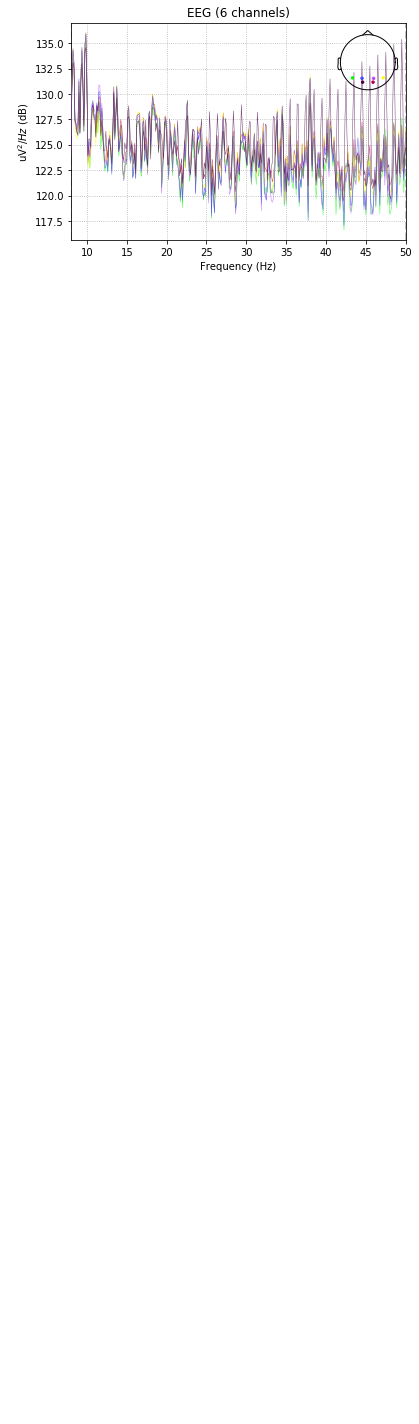

Effective window size : 1.000 (s)
*******Dados após psd_welch*******

*******Dados com filtro bandpass*******



<ipython-input-39-3268eb497e71>:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  newRaw.plot_psd(area_mode='range', fmin=8, fmax=50, tmin=0, tmax=800, verbose=False)


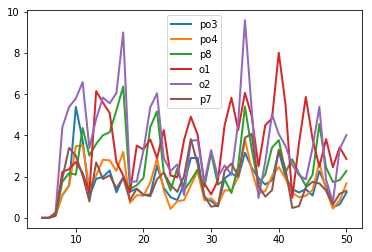

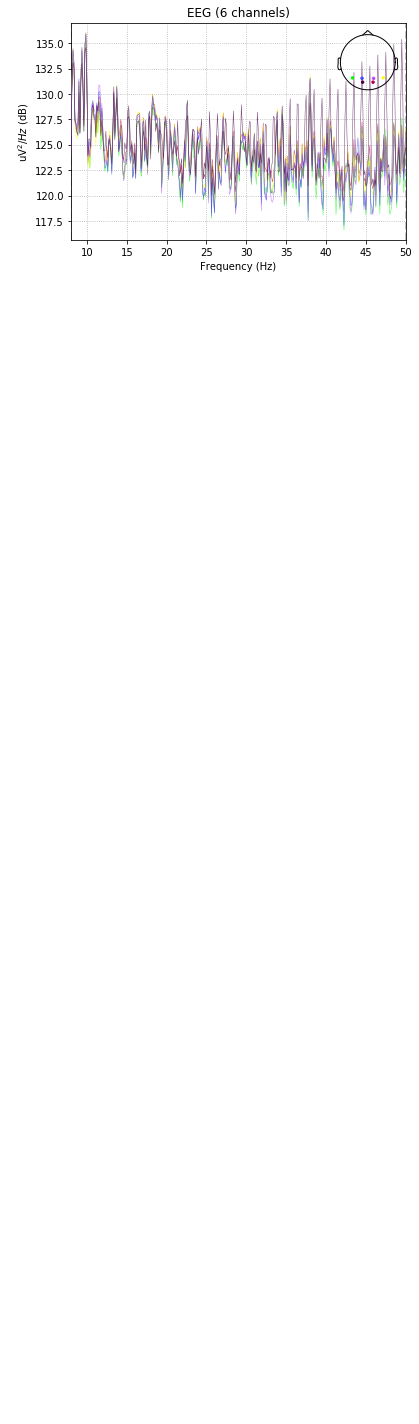

Effective window size : 1.000 (s)
*******Dados após psd_welch*******

*******Dados com filtro bandpass*******



<ipython-input-39-3268eb497e71>:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  newRaw.plot_psd(area_mode='range', fmin=8, fmax=50, tmin=0, tmax=800, verbose=False)


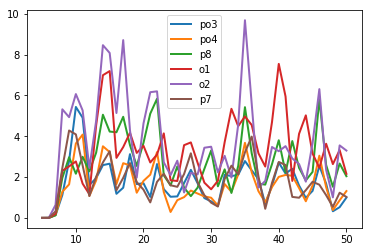

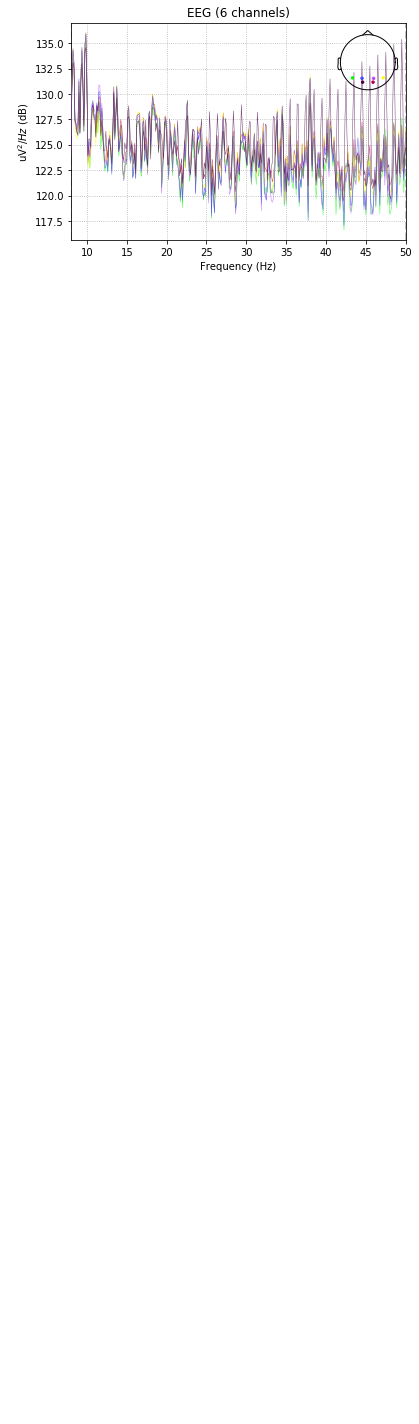

Effective window size : 1.000 (s)
*******Dados após psd_welch*******

*******Dados com filtro bandpass*******



<ipython-input-39-3268eb497e71>:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  newRaw.plot_psd(area_mode='range', fmin=8, fmax=50, tmin=0, tmax=800, verbose=False)


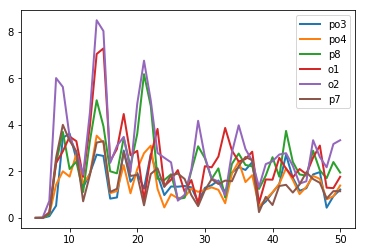

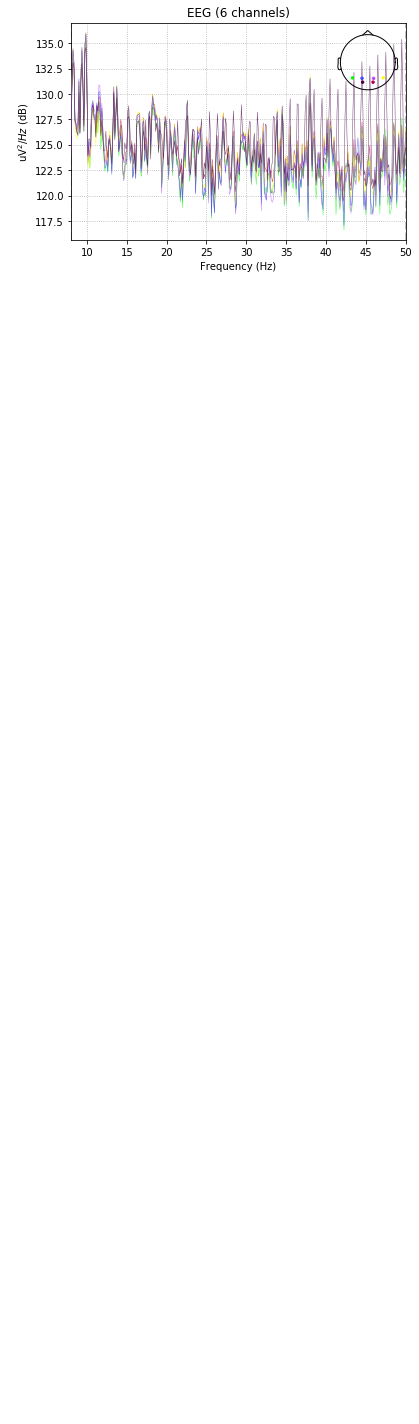

Effective window size : 1.000 (s)
*******Dados após psd_welch*******

*******Dados com filtro bandpass*******



<ipython-input-39-3268eb497e71>:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  newRaw.plot_psd(area_mode='range', fmin=8, fmax=50, tmin=0, tmax=800, verbose=False)


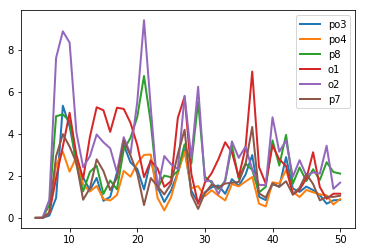

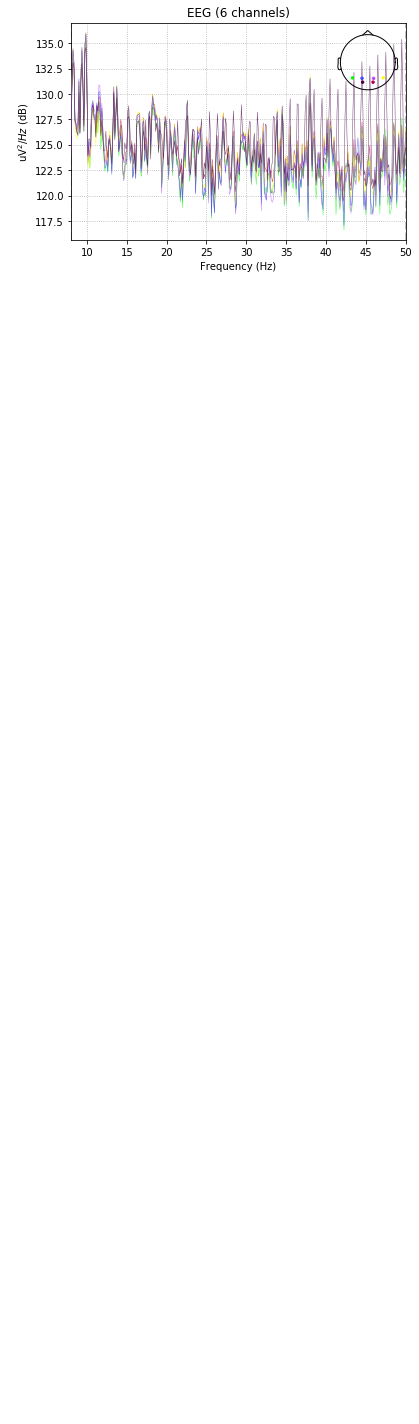

Effective window size : 1.000 (s)
*******Dados após psd_welch*******

*******Dados com filtro bandpass*******



<ipython-input-39-3268eb497e71>:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  newRaw.plot_psd(area_mode='range', fmin=8, fmax=50, tmin=0, tmax=800, verbose=False)


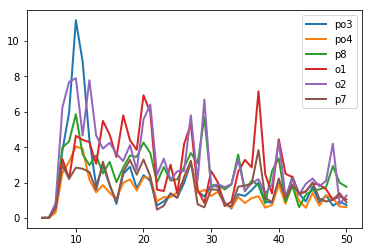

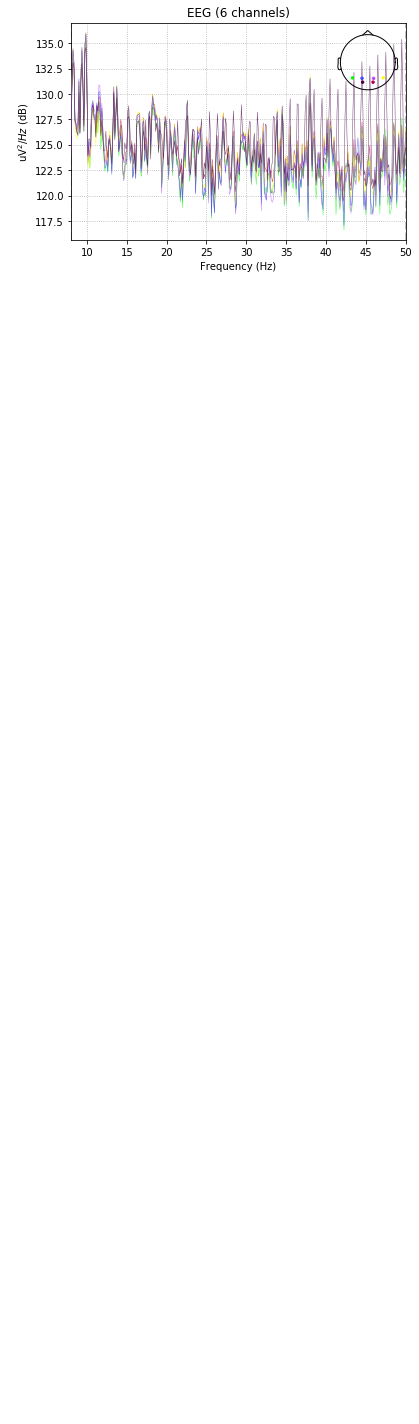

Effective window size : 1.000 (s)
*******Dados após psd_welch*******

*******Dados com filtro bandpass*******



<ipython-input-39-3268eb497e71>:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  newRaw.plot_psd(area_mode='range', fmin=8, fmax=50, tmin=0, tmax=800, verbose=False)


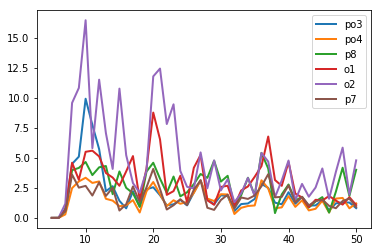

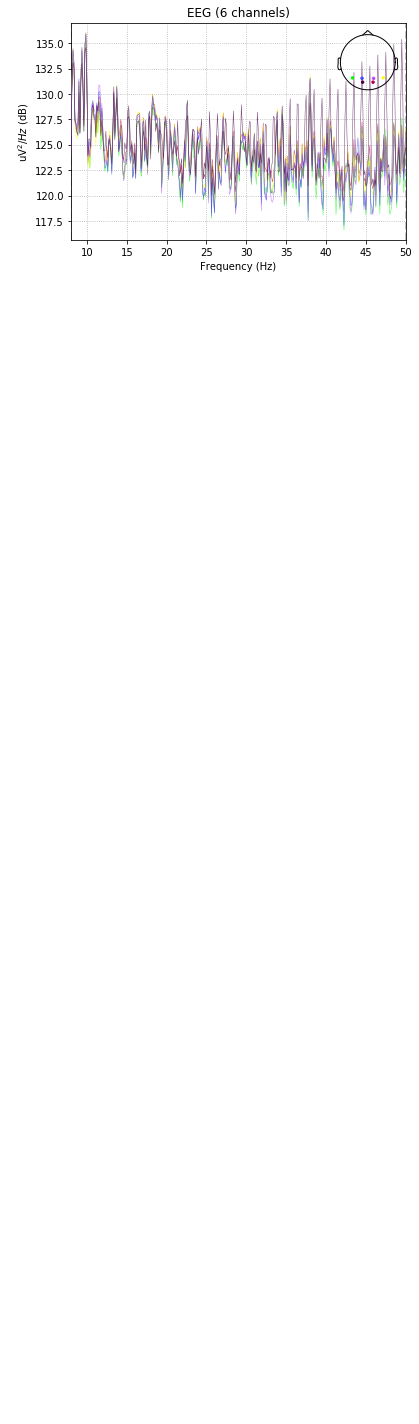

Effective window size : 1.000 (s)
*******Dados após psd_welch*******

*******Dados com filtro bandpass*******



<ipython-input-39-3268eb497e71>:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  newRaw.plot_psd(area_mode='range', fmin=8, fmax=50, tmin=0, tmax=800, verbose=False)


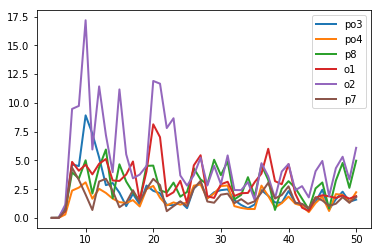

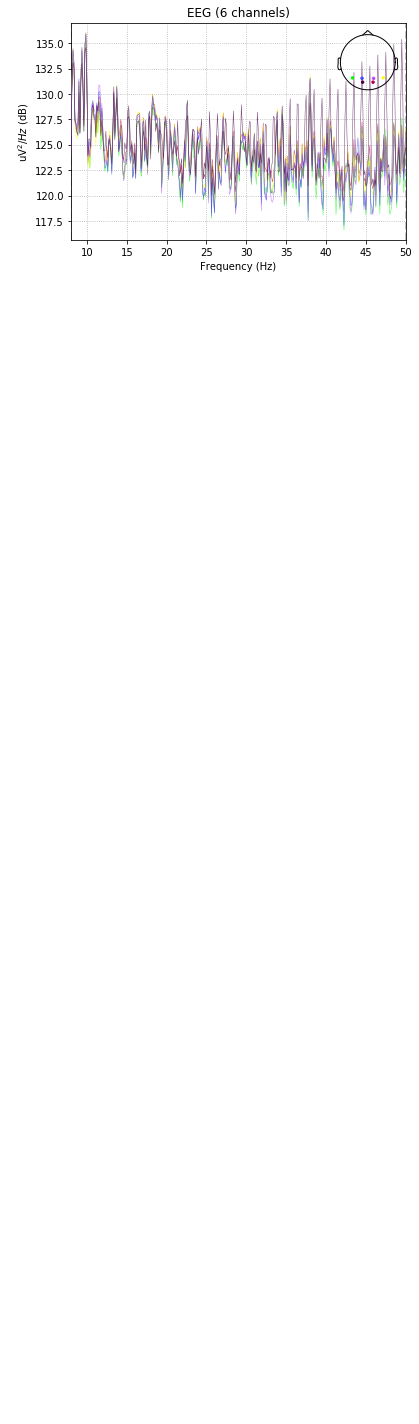

Effective window size : 1.000 (s)
*******Dados após psd_welch*******

*******Dados com filtro bandpass*******



<ipython-input-39-3268eb497e71>:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  newRaw.plot_psd(area_mode='range', fmin=8, fmax=50, tmin=0, tmax=800, verbose=False)


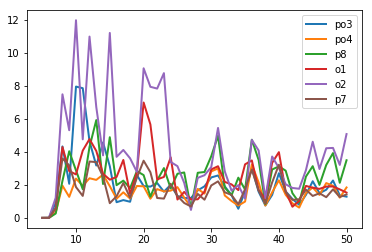

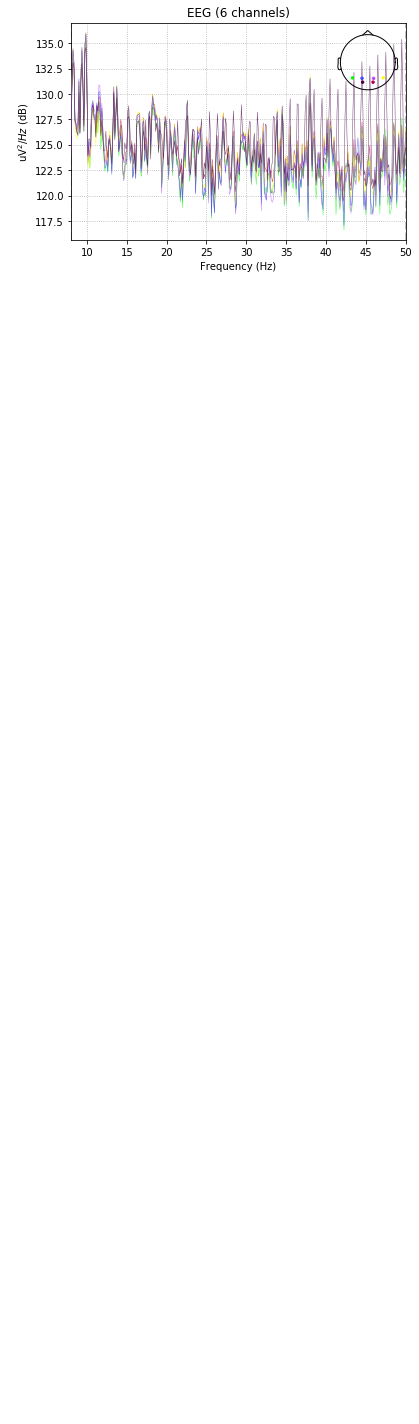

Effective window size : 1.000 (s)
*******Dados após psd_welch*******

*******Dados com filtro bandpass*******



<ipython-input-39-3268eb497e71>:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  newRaw.plot_psd(area_mode='range', fmin=8, fmax=50, tmin=0, tmax=800, verbose=False)


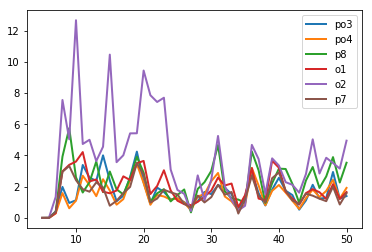

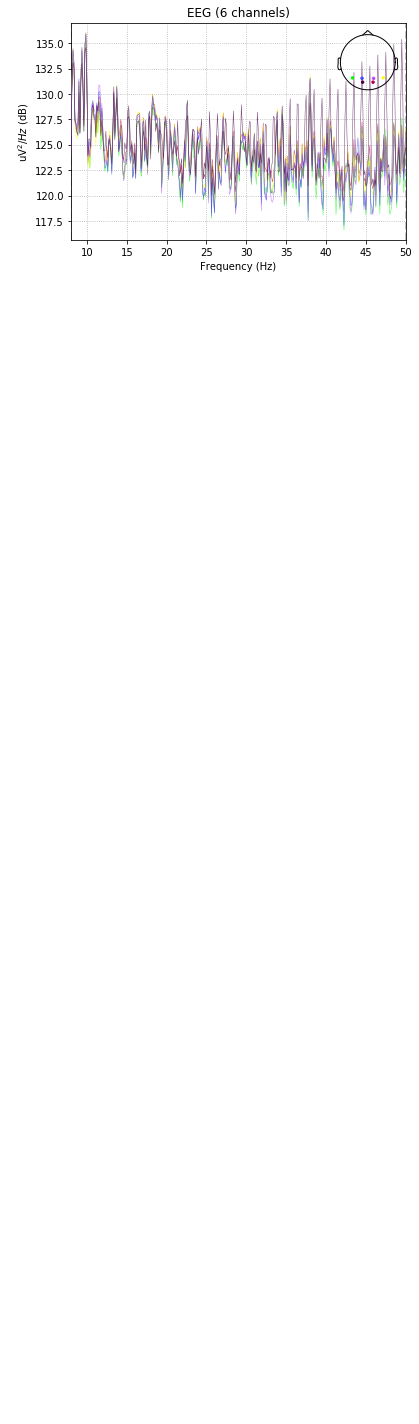

Effective window size : 1.000 (s)
*******Dados após psd_welch*******

*******Dados com filtro bandpass*******



<ipython-input-39-3268eb497e71>:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  newRaw.plot_psd(area_mode='range', fmin=8, fmax=50, tmin=0, tmax=800, verbose=False)


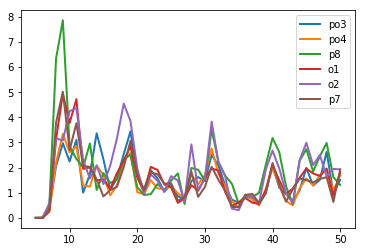

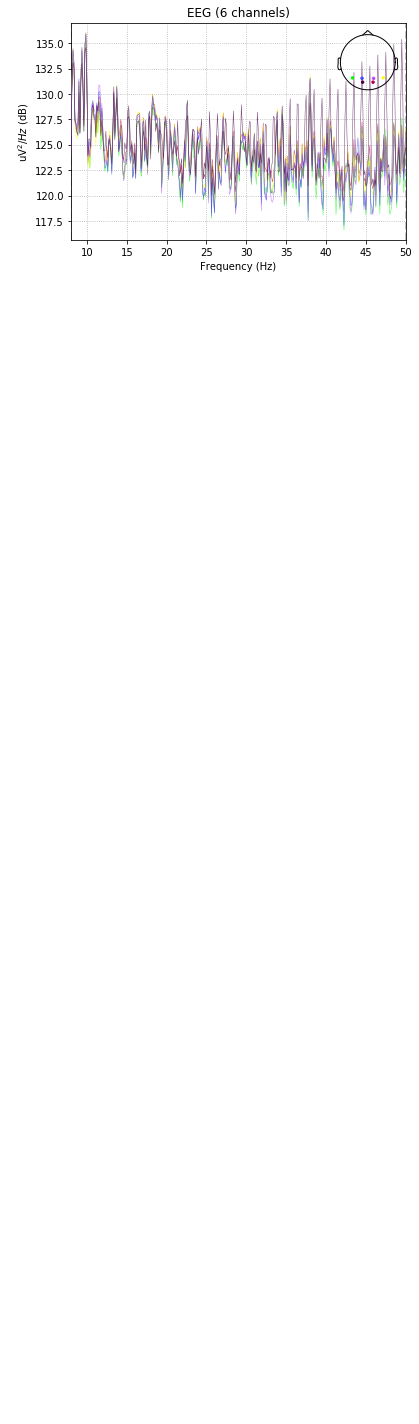

Effective window size : 1.000 (s)
*******Dados após psd_welch*******

*******Dados com filtro bandpass*******



<ipython-input-39-3268eb497e71>:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  newRaw.plot_psd(area_mode='range', fmin=8, fmax=50, tmin=0, tmax=800, verbose=False)


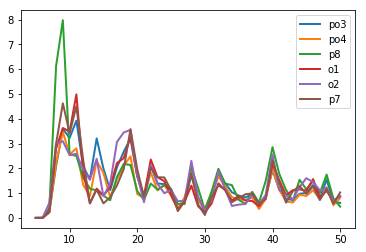

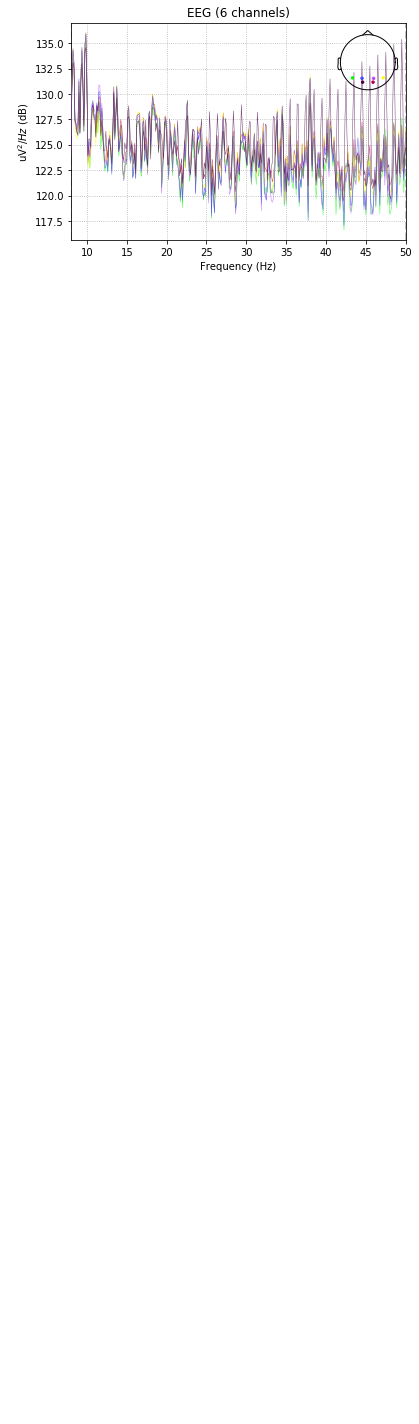

Effective window size : 1.000 (s)
*******Dados após psd_welch*******

*******Dados com filtro bandpass*******



<ipython-input-39-3268eb497e71>:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  newRaw.plot_psd(area_mode='range', fmin=8, fmax=50, tmin=0, tmax=800, verbose=False)


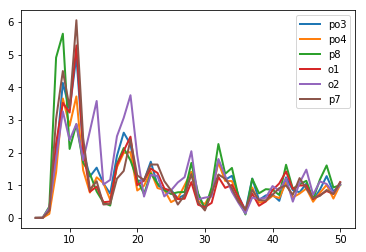

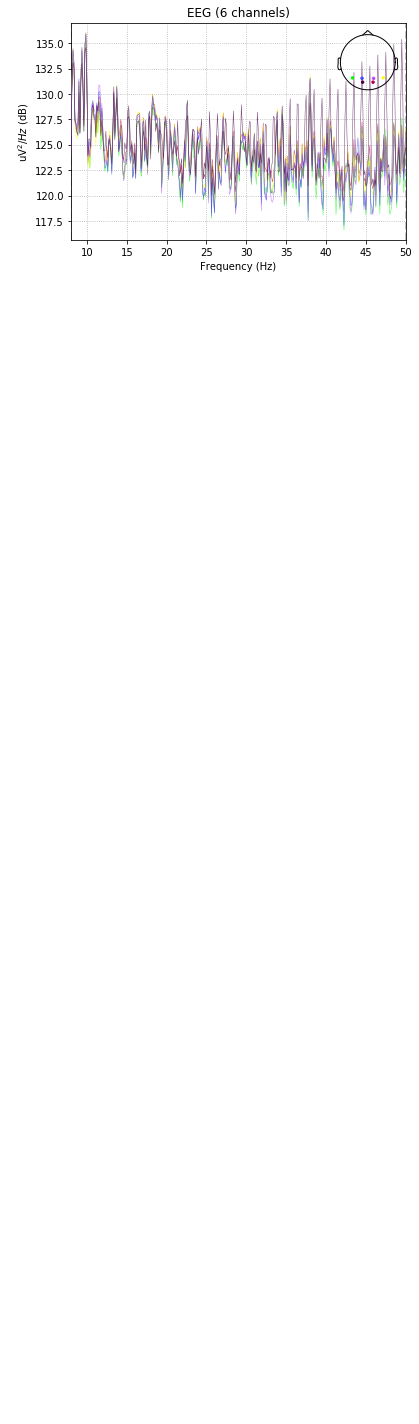

Effective window size : 1.000 (s)
*******Dados após psd_welch*******

*******Dados com filtro bandpass*******



<ipython-input-39-3268eb497e71>:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  newRaw.plot_psd(area_mode='range', fmin=8, fmax=50, tmin=0, tmax=800, verbose=False)


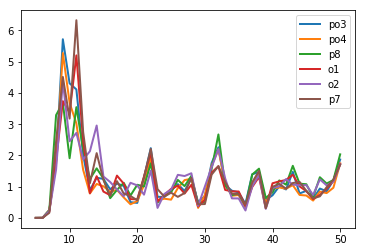

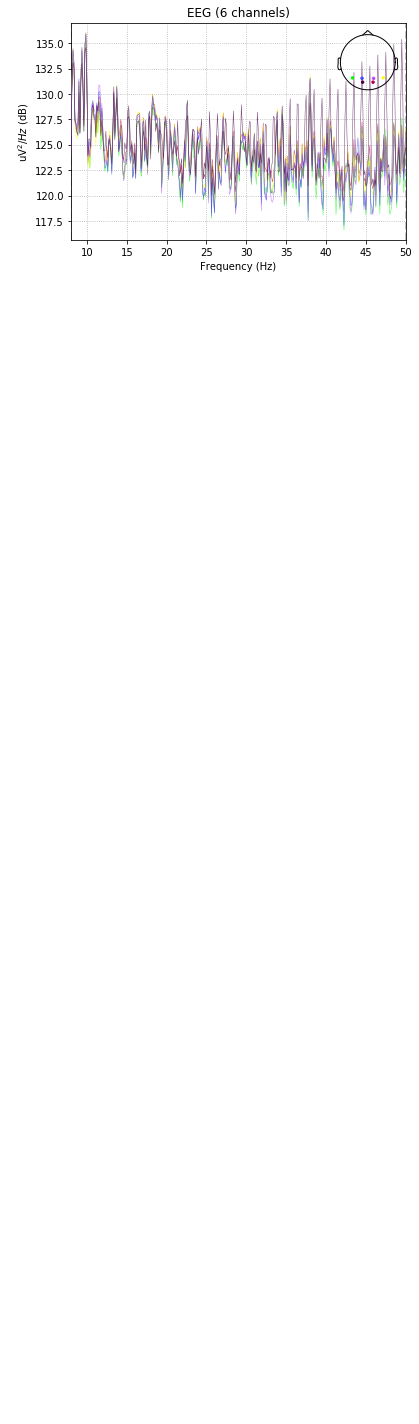

Effective window size : 1.000 (s)
*******Dados após psd_welch*******

*******Dados com filtro bandpass*******



<ipython-input-39-3268eb497e71>:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  newRaw.plot_psd(area_mode='range', fmin=8, fmax=50, tmin=0, tmax=800, verbose=False)


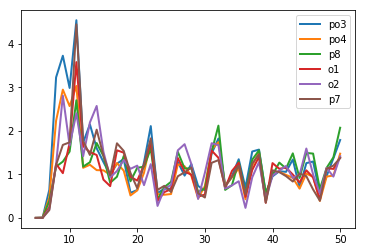

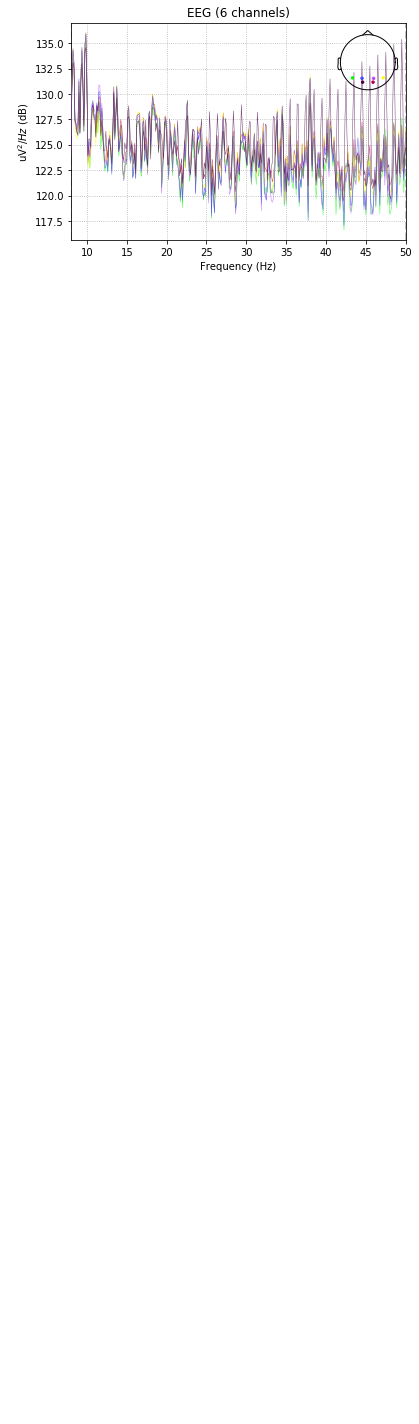

Effective window size : 1.000 (s)
*******Dados após psd_welch*******

522


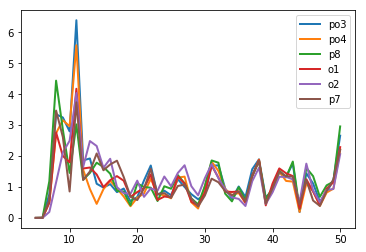

In [53]:
for i in range(0, 40):
    plot_time_frequency(raw, i, i+4)

print(len(md_theta))
# plot_time_frequency(raw, 11, 13)
# plot_time_frequency(raw, 77, 85)
# plot_time_frequency(raw, 121, 122)
# plot_time_frequency(raw, 124, 127)
# plot_time_frequency(raw, 198, 199) #alpha perde
# plot_time_frequency(raw, 244, 250)
# plot_time_frequency(raw, 252, 258)
# plot_time_frequency(raw, 300, 304)
# plot_time_frequency(raw, 314, 320)
# plot_time_frequency(raw, 410, 411)
# plot_time_frequency(raw, 607, 611)
# plot_time_frequency(raw, 0, 830) #intervalo completo

### 10. Média para cada tipo de frequência

A função a seguir salva a média para tipo de frequência conforme o eletrodo.

In [43]:
def avg_freq():
    for i in range(0, 6):
        md_theta.append(avg(theta[i]))
        md_alpha.append(avg(alpha[i]))
        md_beta.append(avg(beta[i]))
        md_gamma.append(avg(gamma[i]))

### 11. Extraindo os maiores valores de média

A função *large\-md* retorna o valor da maior média dentre todas as frequências.

In [50]:
avg_freq()

print(theta)

def large_md(data):
    maior = -1
    pos = 0
    pos_aux = pos
   
    for i in range(0, len(data)):
        for element in data[i]:
            if element > maior:
                maior = element
                pos = pos_aux
            pos_aux += 1
        pos_aux = 0
    return pos

[array([0.02641354, 0.01278481, 0.62848816]), array([0.18464171, 0.07880396, 1.5846791 ]), array([0.02697139, 0.02490832, 0.80907242]), array([0.00610846, 0.00395421, 0.32895273]), array([0.00197862, 0.00096167, 0.06678514]), array([0.00179942, 0.00083665, 0.29046337]), array([0.0022522 , 0.00110351, 0.29985904]), array([0.00773251, 0.00404209, 0.26977358]), array([0.00239134, 0.00311001, 0.73605157]), array([0.00062526, 0.00099081, 0.52146625]), array([0.0013047 , 0.00048953, 0.12720178]), array([0.0013447 , 0.00118029, 0.40981047]), array([0.00335572, 0.00116753, 0.20366778]), array([0.00154702, 0.00308294, 0.43554001]), array([0.00238887, 0.0024324 , 0.90398851]), array([3.15196778e-04, 1.77118560e-03, 4.65802627e-01]), array([0.00165236, 0.00105665, 0.47102061]), array([0.00071427, 0.00144351, 0.36908906]), array([0.00300094, 0.00115815, 0.29442495]), array([0.00108107, 0.00265533, 0.43611792]), array([0.00177156, 0.00332752, 0.85552705]), array([3.27019852e-04, 1.67822204e-03, 3.4

### 12. Comparação das médias

In [ ]:
md_ritmos.append(md_alpha)
md_ritmos.append(md_beta)
md_ritmos.append(md_gamma)
md_ritmos.append(md_theta)

eletrodo_tds_ritmos = large_md(md_ritmos)
print("Comparação do maior valor em eletrodo considerando todos os ritmos:")
print("Eletrodo: ", end = '')
print(ch_names[eletrodo_tds_ritmos])
print("Alpha (8-12)Hz: ", end = '')
print(md_alpha[eletrodo_tds_ritmos])
print("Beta (12-30)Hz: ", end = '')
print(md_beta[eletrodo_tds_ritmos])
print("Gamma (25-50)Hz: ", end = '')
print(md_gamma[eletrodo_tds_ritmos])
print("Theta (4-7)Hz: ", end = '')
print(md_theta[eletrodo_tds_ritmos])
print("\n")

### 13. Mapeamento para uma escala

Por fim, a seguir é feito um mapeamento da diferença entre o valor da média de *alpha* e o segundo maior valor de média para uma escala que varia de 0 à 100. 

In [ ]:
segundo_maior = max(md_beta[eletrodo_tds_ritmos], md_theta[eletrodo_tds_ritmos], md_gamma[eletrodo_tds_ritmos])
diferenca = md_alpha[eletrodo_tds_ritmos] - segundo_maior
escala = (100*diferenca)/md_alpha[eletrodo_tds_ritmos]
print("Média de alpha: ", md_alpha[eletrodo_tds_ritmos])
print("Segunda maior média: ", segundo_maior)
print("Valor na escala: ", escala)